# Amazon books reommendation system with HPF & MCC

In this notebook I am implementing the hierarchical poisson factorization (HPF) using Markov chain Monte Carlo (MCMC).

I am using an amazon dataset with ratings for books.
The dataset is availabel on Kaggle: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

## Imports

I will start by importing all the needed libraries.

In [80]:
import pymc3 as pm
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import json
import ast
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings

## Dataset

### Loading data

The dataset consist of 2 csv files 

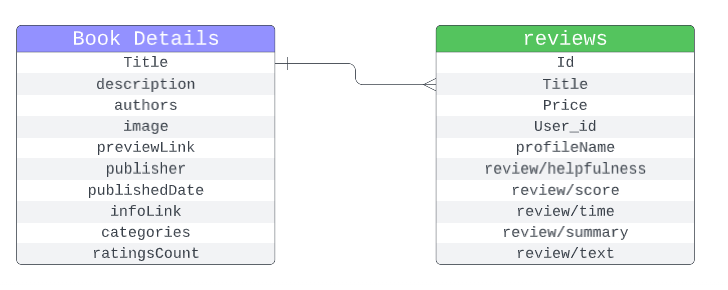

#### Books data

I am going to keep only a few attributes that can be easly used in the model, and drop the other ones, like the book description, image and links.

In [33]:
books_df = pd.read_csv('archive/books_data.csv').rename(columns={'Title': 'title'})
selected_columns = ['title', 'authors', 'publisher', 'publishedDate', 'categories', 'ratingsCount']
books_df = books_df[selected_columns]
books_df = books_df.dropna()

book_mapping = {title: i for i, title in enumerate(books_df['title'].unique())}
books_df['book_id'] = books_df['title'].map(book_mapping)
books_df = books_df.drop(columns=['title'])

books_df['authors'] = books_df['authors'].apply(ast.literal_eval)
books_df['categories'] = books_df['categories'].apply(ast.literal_eval)

books_df['publishedDate'] = books_df['publishedDate'].str[:4]

#### Reviews data

In the same way, we are keeping only few attributes for reviews, and drop the other ones, like the profile name (we have the user id).

In [34]:
ratings_df = pd.read_csv('archive/Books_rating.csv').rename(columns={'Title': 'title'}).rename(columns={'User_id': 'user_id'}).rename(columns={'Id': 'id'})
selected_columns = ['id', 'title', 'user_id', 'review/helpfulness', 'review/score', 'review/time']
ratings_df = ratings_df[selected_columns]
ratings_df = ratings_df.dropna()

review_mapping = {id: i for i, id in enumerate(ratings_df['id'].unique())}
user_mapping = {id: i for i, id in enumerate(ratings_df['user_id'].unique())}
ratings_df['review_id'] = ratings_df['id'].map(review_mapping)
ratings_df = ratings_df.drop(columns=['id'])
ratings_df['user_id'] = ratings_df['user_id'].map(user_mapping)

ratings_df['book_id'] = ratings_df['title'].map(book_mapping)
ratings_df = ratings_df.drop(columns=['title'])
ratings_df = ratings_df.dropna()

#### Mapings

I am going to use own ids. For that, I am going to save to mappings between my ids and the original ones.

In [35]:
mappings = {
    "book_id": book_mapping,
    "review_id": review_mapping,
    "user_id": user_mapping,
}
with open("mappings.json", 'w') as json_file:
    json.dump(mappings, json_file, indent=4)

#### Filtering

I am keeping only the books that have reviews. For the other ones we basically don't have data for prediction.

In [36]:
unique_book_ids = ratings_df['book_id'].unique()
books_df = books_df[books_df['book_id'].isin(unique_book_ids)]

### Statistics

Now we can take a closer look to the data.

In [37]:
print(books_df.head())
print()
print(ratings_df.head())

                  authors                   publisher publishedDate  \
5      [Everett Ferguson]  Wm. B. Eerdmans Publishing          1996   
31          [Rupert Fike]     Book Publishing Company          2012   
33     [Stefan Draminski]       Bloomsbury Publishing          2018   
42       [May Mcgoldrick]              Harper Collins          2002   
43  [Kayode J. Fakinlede]            Hippocrene Books          2005   

                     categories  ratingsCount  book_id  
5                    [Religion]           5.0        0  
31  [Biography & Autobiography]           1.0        1  
33                    [History]           1.0        2  
42           [Juvenile Fiction]           2.0        3  
43     [Foreign Language Study]           1.0        4  

     user_id review/helpfulness  review/score  review/time  review_id  book_id
47        47              74/81           5.0    955411200          5      0.0
48        48                2/3           5.0   1311465600          5   

We can check how many books have review. Also notice that indeed, I keep the same amout of books in both dataframes

In [38]:
print(f"Number of books in books_df: {books_df['book_id'].nunique()}")
print(f"Number of books in ratings_df: {ratings_df['book_id'].nunique()}")

Number of books in books_df: 41675
Number of books in ratings_df: 41675


Let's see how many unique values do we have

In [39]:
all_authors = set([author for sublist in books_df['authors'] for author in sublist])
all_categories = set([author for sublist in books_df['categories'] for author in sublist])
all_publishers = set(books_df['publisher'].unique())
all_published_dates = set(books_df['publishedDate'].unique())
print(f"Number of authors: {len(all_authors)}")
print(f"Number of publishers: {len(all_publishers)}")
print(f"Number of published dates: {len(all_published_dates)}")
print(f"Number of categories: {len(all_categories)}")

Number of authors: 32971
Number of publishers: 5069
Number of published dates: 153
Number of categories: 1442


There are about 10 times more users than books, so we may expect to have an average fo 10 reviews per book.

In [40]:
all_users = set(ratings_df['user_id'].unique())
all_books = set(ratings_df['book_id'].unique())
print(f"Number of users: {len(all_users)}")
print(f"Number of books: {len(all_books)}")

Number of users: 541042
Number of books: 41675


We can see that most of the reviews have high ratings.

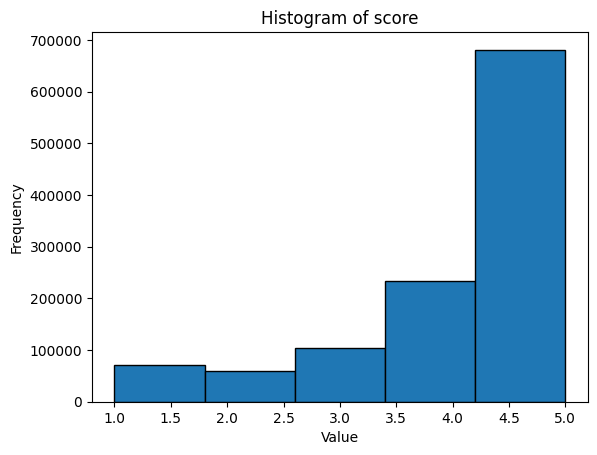

In [41]:
plt.hist(ratings_df['review/score'], bins=5, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of score')
plt.show()

I am gonne use hist_book function to visualise how many books have the same certain attribute. Like how many books have same authore or category and so on.

In [42]:
def hist_of_books(all_individuals, individuals_type, df, is_list = True):
    freq = {individual: 0 for individual in all_individuals}

    for index, row in tqdm(df.iterrows(), total=len(books_df)):
        individuals = row[individuals_type]
        if is_list:
            for individual in individuals:
                freq[individual] += 1
        else:
            freq[individuals] += 1

    # Extract counts from the dictionary
    values = list(freq.values())

    # Create a histogram
    plt.hist(values, bins=np.arange(min(values), max(values) + 1.5) - 0.5, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of books by same {individuals_type}')
    plt.show()

    for k in range(1, 11):
        print(f" Number of {individuals_type} that have {k} books: {values.count(k)}")

    plt.hist(values, bins=10, range=(1, 11), edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of books by same {individuals_type}')
    plt.show()

There are very few books by the same author. So keeping the author as an attribute migh be useless.

  5%|▍         | 1958/41675 [00:00<00:02, 19575.63it/s]

100%|██████████| 41675/41675 [00:01<00:00, 22116.33it/s]


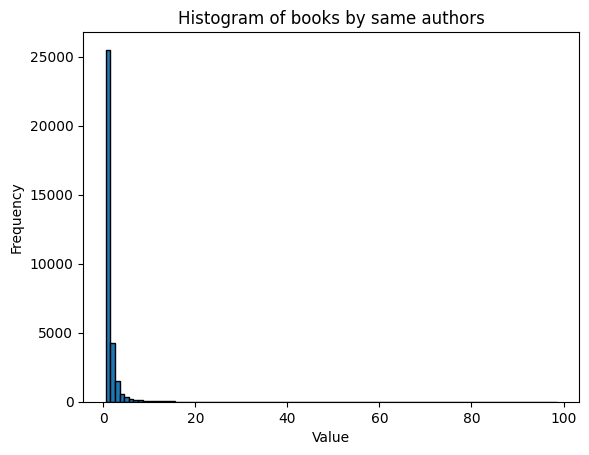

 Number of authors that have 1 books: 25510
 Number of authors that have 2 books: 4290
 Number of authors that have 3 books: 1480
 Number of authors that have 4 books: 567
 Number of authors that have 5 books: 327
 Number of authors that have 6 books: 200
 Number of authors that have 7 books: 142
 Number of authors that have 8 books: 93
 Number of authors that have 9 books: 69
 Number of authors that have 10 books: 58


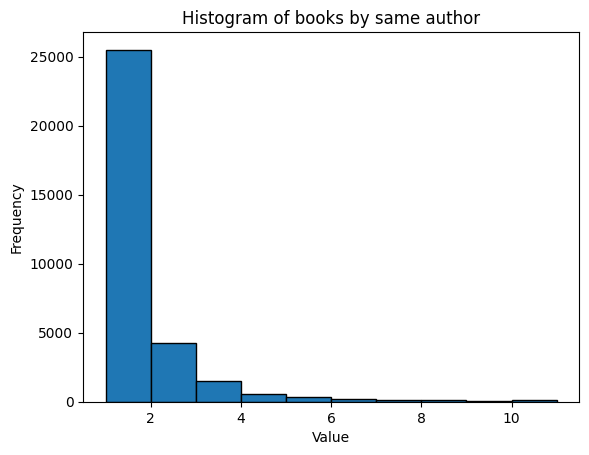

In [43]:
hist_of_books(all_authors, "authors", books_df)

The same effect goes on for publisher too.

100%|██████████| 41675/41675 [00:01<00:00, 22082.72it/s]


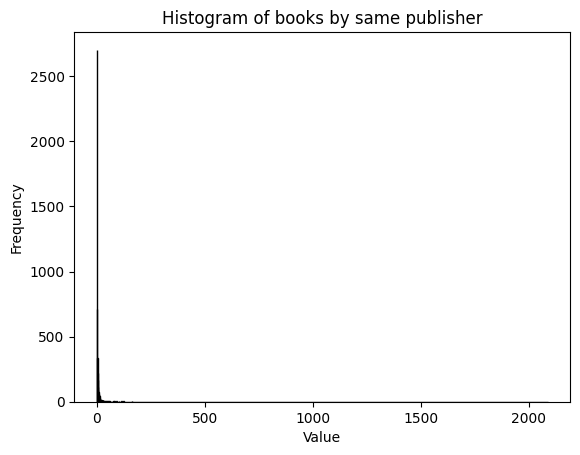

 Number of publisher that have 1 books: 2704
 Number of publisher that have 2 books: 712
 Number of publisher that have 3 books: 335
 Number of publisher that have 4 books: 222
 Number of publisher that have 5 books: 166
 Number of publisher that have 6 books: 112
 Number of publisher that have 7 books: 93
 Number of publisher that have 8 books: 73
 Number of publisher that have 9 books: 59
 Number of publisher that have 10 books: 51


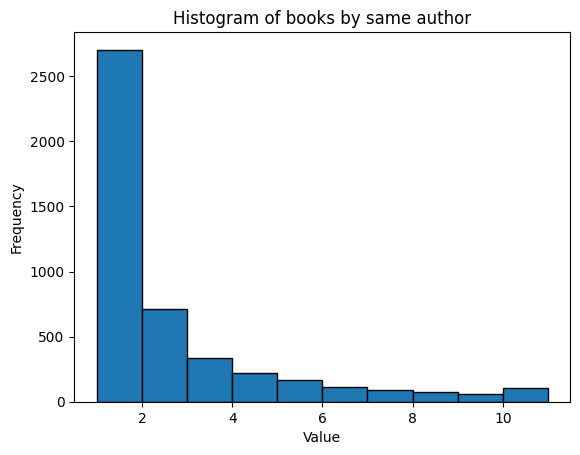

In [44]:
hist_of_books(all_publishers, "publisher", books_df, is_list=False)

There seam to be a lot of books that share the same year.

100%|██████████| 41675/41675 [00:01<00:00, 21899.62it/s]


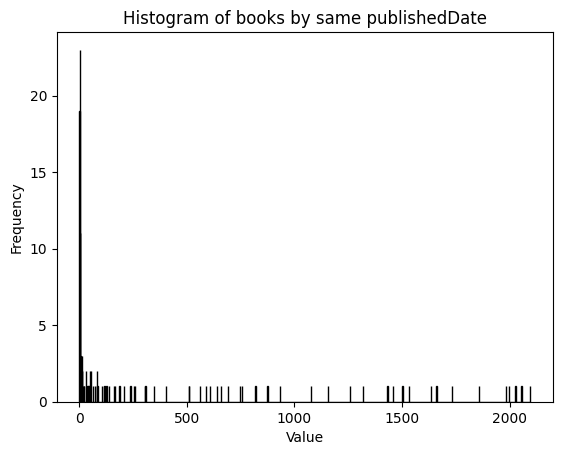

 Number of publishedDate that have 1 books: 19
 Number of publishedDate that have 2 books: 23
 Number of publishedDate that have 3 books: 11
 Number of publishedDate that have 4 books: 11
 Number of publishedDate that have 5 books: 3
 Number of publishedDate that have 6 books: 3
 Number of publishedDate that have 7 books: 3
 Number of publishedDate that have 8 books: 1
 Number of publishedDate that have 9 books: 1
 Number of publishedDate that have 10 books: 1


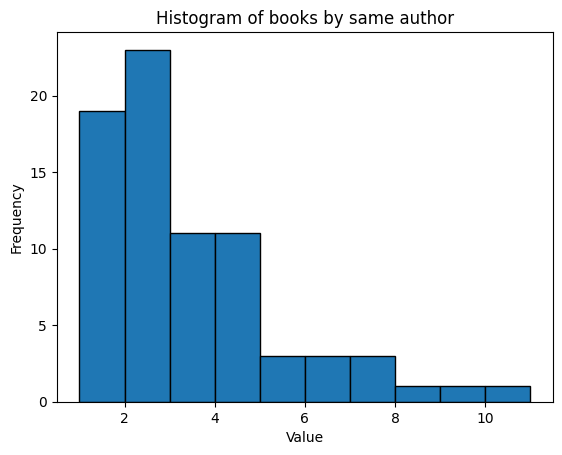

In [45]:
hist_of_books(all_published_dates, "publishedDate", books_df, is_list=False)

There are also a lot of books that share the same category. For example, there are 41675 (total number of books) - 1001 (number fo books that ddoes not share catory) = 40674 books that share category with at least one other book.

100%|██████████| 41675/41675 [00:01<00:00, 22542.58it/s]


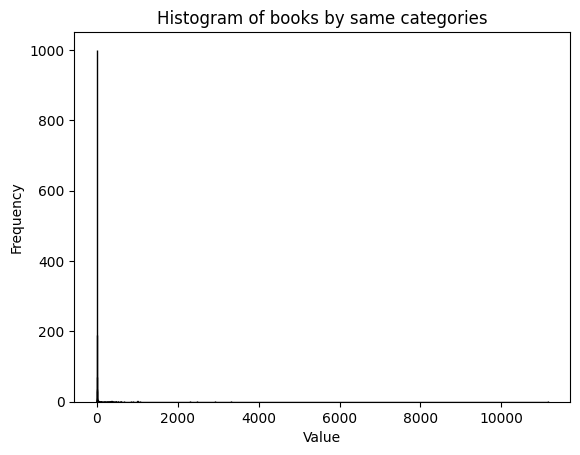

 Number of categories that have 1 books: 1001
 Number of categories that have 2 books: 191
 Number of categories that have 3 books: 71
 Number of categories that have 4 books: 36
 Number of categories that have 5 books: 30
 Number of categories that have 6 books: 11
 Number of categories that have 7 books: 5
 Number of categories that have 8 books: 4
 Number of categories that have 9 books: 9
 Number of categories that have 10 books: 4


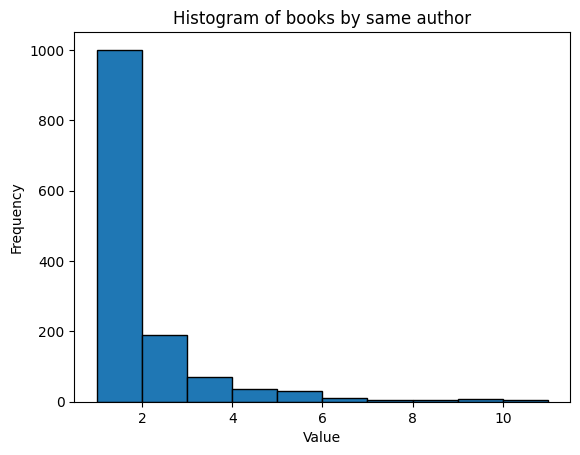

In [46]:
hist_of_books(all_categories, "categories", books_df)

I am gonna use the below function to check this time the frequency of review either made by the user or recived by the book.

In [47]:
def frequency(all_individuals, type, df):
    freq = {individual: 0 for individual in all_individuals}

    for index, row in tqdm(df.iterrows(), total=len(books_df)):
        freq[row[type]] += 1

    # Extract counts from the dictionary
    values = list(freq.values())

    # Plotting the first histogram
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.hist(values, bins=np.arange(min(values), max(values) + 1.5) - 0.5, edgecolor='black', density=True)
    plt.xlabel('Value')
    plt.ylabel('Normalized Frequency')
    plt.title(f'Histogram of {type} by number of reviews')

    plt.tight_layout()
    plt.show()

    # Printing the counts for each k
    for k in range(1, 11):
        print(f" Number of {type} that have {k} reviews: {values.count(k)}")

    # Plotting the second histogram
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.hist(values, bins=50, range=(1, 51), edgecolor='black', density=True)
    plt.xlabel('Value')
    plt.ylabel('Normalized Frequency')
    plt.title(f'Histogram of {type} by number of reviews')

    plt.tight_layout()
    plt.show()

    return freq

Most of the user made only one review. This is not a very good news.

  0%|          | 0/41675 [00:00<?, ?it/s]

1149166it [00:52, 21962.90it/s]                         


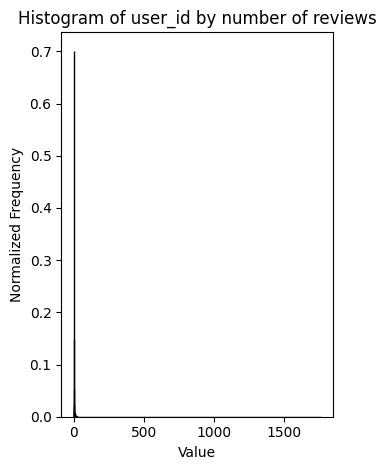

 Number of user_id that have 1 reviews: 379475
 Number of user_id that have 2 reviews: 80167
 Number of user_id that have 3 reviews: 28804
 Number of user_id that have 4 reviews: 13536
 Number of user_id that have 5 reviews: 10399
 Number of user_id that have 6 reviews: 7648
 Number of user_id that have 7 reviews: 3906
 Number of user_id that have 8 reviews: 2782
 Number of user_id that have 9 reviews: 1758
 Number of user_id that have 10 reviews: 1637


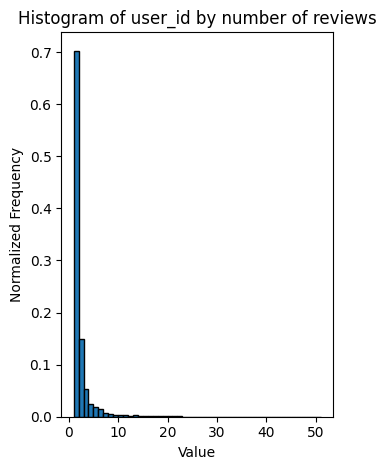

In [48]:
user_freq = frequency(all_users, "user_id", ratings_df)

The distribution above seem to be very similar to a gamma of alpha=1 and beta=2

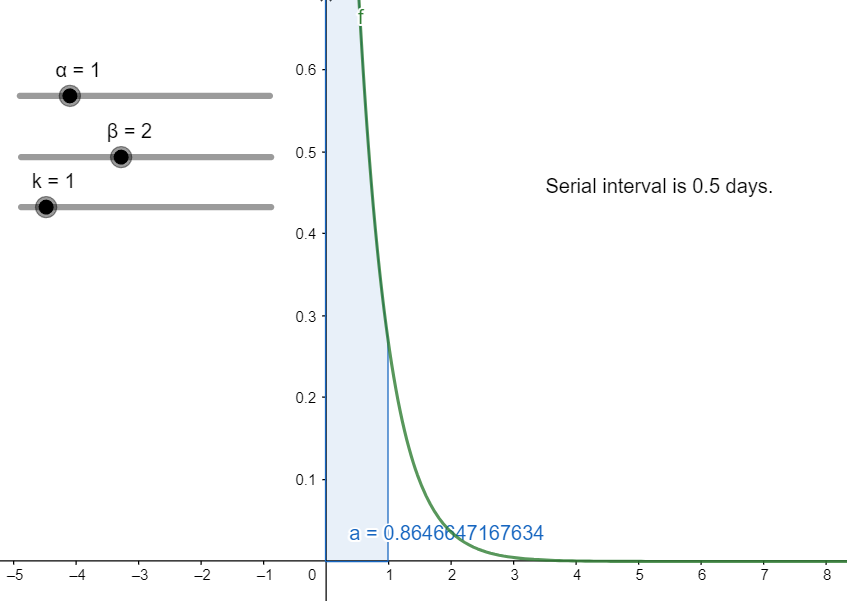

Instead, most of the books have recived at least 2 review. We did expect that because the number of users is way bigger that the one of books

1149166it [00:52, 21888.53it/s]                         


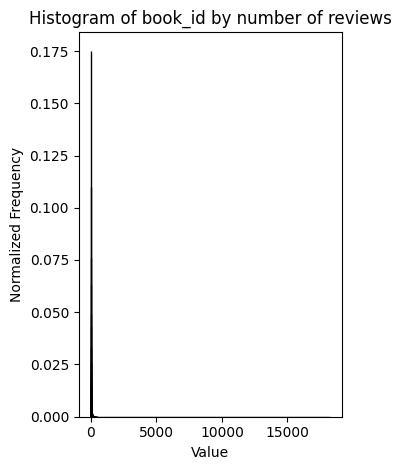

 Number of book_id that have 1 reviews: 7301
 Number of book_id that have 2 reviews: 4573
 Number of book_id that have 3 reviews: 3162
 Number of book_id that have 4 reviews: 2627
 Number of book_id that have 5 reviews: 2057
 Number of book_id that have 6 reviews: 1806
 Number of book_id that have 7 reviews: 1410
 Number of book_id that have 8 reviews: 1371
 Number of book_id that have 9 reviews: 1082
 Number of book_id that have 10 reviews: 1072


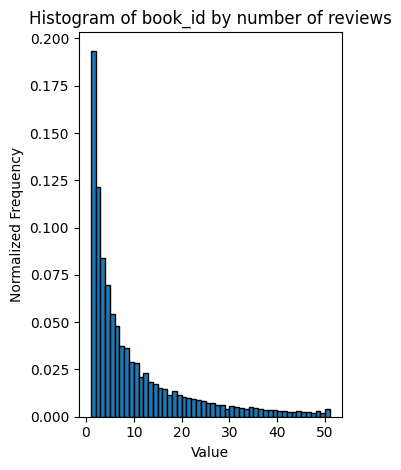

In [49]:
book_freq = frequency(all_books, "book_id", ratings_df)

The distribution above seem to be very similar to a gamma of alpha=1 and beta=0.5

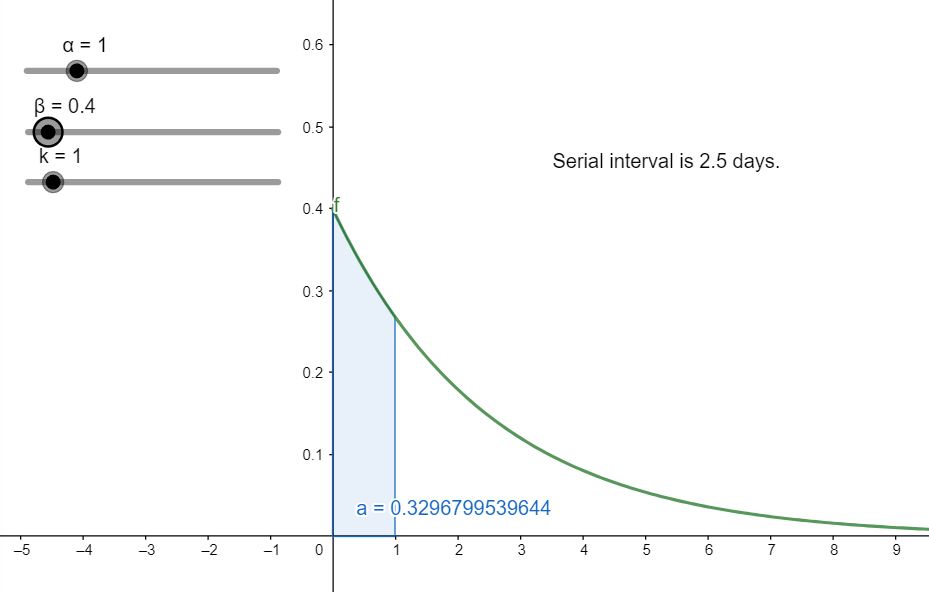

## Sanity Check

For the sanity check I am using only 10 users and 10 books.

### Train data


I am randomly sampling the number of review that an selected user should have (ie. the frequency). After that, I am trying to find this kind of user and take books that they have reviewed.

By doing so, we make sure that we cover a wide type of users, some of them more active and some less.

In [50]:
n = 10
selected_user_freq = sorted(np.random.randint(low=1, high=50, size=n), reverse=True)
categorie_treshold = n // 3
selected_categories = []

selected_users = set()
selected_books = set()


for k, value in enumerate(selected_user_freq):
    for user_id in user_freq.keys():
        if user_freq[user_id] == value:
            book_id = ratings_df[ratings_df["user_id"] == user_id].iloc[0]["book_id"]
            categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
            included = False
            for c in categories:
                if c in selected_categories:
                    included = True
            if (k <= categorie_treshold and (len(selected_categories) == 0 or not included)) or (k > categorie_treshold and included):
                for c in categories:
                    selected_categories.append(c)

                if len(selected_users) < n:
                    selected_users.add(user_id)
                if len(selected_books) < n:
                    selected_books.add(book_id)
                if len(selected_books) == n or k <= categorie_treshold:
                    break

print(len(selected_users), len(selected_books))

10 10


We will take the frequency of reviews for both users and books, in order to use this information inside the models.

In [52]:
selected_users_freq = [user_freq[id] for id in selected_users if id in user_freq.keys()]
selected_books_freq = [book_freq[id] for id in selected_books if id in book_freq.keys()]
print(len(selected_users_freq), len(selected_books_freq))

10 10


We are also interested about the user preferences. So we can consider a vector with numbers for each type of book (category). We are going to measure how much the user like each category by making a weighted sum of given reviews.

For example.
If user 0 made 2 reviews of rating 5 and 3 to a certain category, than that category will have a final value of 8. Howevere, we will normalize this values for numerical reasons.

This vectores have the same lenght as the total number of book category, which is more than 1000.
To compress this vector, we can keep only the index of the category that they liked the most.

In [53]:
old_selected_users_preferences = np.zeros((len(selected_users),len(all_categories)))

for k, user_id in enumerate(selected_users):
    relevant_book_ids = ratings_df[ratings_df['user_id'] == user_id]['book_id'].unique()
    filtered_books_df = books_df[books_df['book_id'].isin(relevant_book_ids)]['book_id'].values

    for book_id in filtered_books_df:
        categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
        for c in categories:
            index = list(all_categories).index(c)
            old_selected_users_preferences[k][index] += 1

    old_selected_users_preferences[k] = old_selected_users_preferences[k] / np.sum(old_selected_users_preferences[k])

selected_users_preferences = np.zeros(len(selected_users))
for k in range(len(selected_users_preferences)):
    selected_users_preferences[k] = np.argmax(old_selected_users_preferences[k])

We are going to define a book by it's cateogries. Although the plural dosen't really make sense here, as in this case, there is no book with more than one categorie.

As previous, we will keep both vectors with all categories (1 for the index of the category and 0 for other) and a compressed version, only with the index of the category for each book.

In [54]:
old_selected_books_atributes = np.zeros((len(selected_books), len(all_categories)))

for k, book_id in enumerate(selected_books):
    categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
    for c in categories:
        index = list(all_categories).index(c)
        old_selected_books_atributes[k][index] += 1

    old_selected_books_atributes[k] = old_selected_books_atributes[k] / np.sum(old_selected_books_atributes[k])

selected_books_atributes = np.zeros(len(selected_books))
for k in range(len(selected_books_atributes)):
    selected_books_atributes[k] = np.argmax(old_selected_books_atributes[k])

Furthere more we are gonna define the rating matrix between the users and books.
This means that on position i, j we have the rating that the user i gave to book j.

In [55]:
ratings_df['user_id'] = ratings_df['user_id'].astype(int)
ratings_df['book_id'] = ratings_df['book_id'].astype(int)
print(len(selected_users), len(selected_books))

# Filter the DataFrame based on selected users and books
interactions_sparse = np.zeros((len(selected_users), len(selected_books)), dtype=int)

selected_rows = ratings_df[(ratings_df['user_id'].isin(selected_users)) & (ratings_df['book_id'].isin(selected_books))]
user_mapping = {user_id: u for u, user_id in enumerate(selected_users)}
book_mapping = {book_id: b for b, book_id in enumerate(selected_books)}

interactions_sparse[selected_rows['user_id'].map(user_mapping), selected_rows['book_id'].map(book_mapping)] = selected_rows['review/score'].values

# Display the resulting matrix
print("Matrix:")
print(interactions_sparse.shape)

n_users, n_items = interactions_sparse.shape

10 10
Matrix:
(10, 10)


### Test Data

We are gonna keep the last 10 users and books as test data.

In [57]:
n = 10

test_selected_users = ratings_df['user_id'].tail(n)
test_selected_books = ratings_df['book_id'].tail(n)

We are amking the same processing as before

In [59]:
test_selected_users_freq = [user_freq[id] for id in test_selected_users if id in user_freq.keys()]
test_selected_books_freq = [book_freq[id] for id in test_selected_books if id in book_freq.keys()]
print(len(test_selected_users_freq), len(test_selected_books_freq))

10 10


In [60]:
test_old_selected_users_preferences = np.zeros((len(test_selected_users),len(all_categories)))

for k, user_id in enumerate(test_selected_users):
    relevant_book_ids = ratings_df[ratings_df['user_id'] == user_id]['book_id'].unique()
    filtered_books_df = books_df[books_df['book_id'].isin(relevant_book_ids)]['book_id'].values

    for book_id in filtered_books_df:
        categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
        for c in categories:
            index = list(all_categories).index(c)
            test_old_selected_users_preferences[k][index] += 1

    test_old_selected_users_preferences[k] = test_old_selected_users_preferences[k] / np.sum(test_old_selected_users_preferences[k])

test_selected_users_preferences = np.zeros(len(test_selected_users))
for k in range(len(selected_users_preferences)):
    test_selected_users_preferences[k] = np.argmax(test_old_selected_users_preferences[k])

In [61]:
test_old_selected_books_atributes = np.zeros((len(test_selected_books), len(all_categories)))

for k, book_id in enumerate(test_selected_books):
    categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
    for c in categories:
        index = list(all_categories).index(c)
        test_old_selected_books_atributes[k][index] += 1

    test_old_selected_books_atributes[k] = test_old_selected_books_atributes[k] / np.sum(test_old_selected_books_atributes[k])

test_selected_books_atributes = np.zeros(len(test_selected_books))
for k in range(len(test_selected_books_atributes)):
    test_selected_books_atributes[k] = np.argmax(test_old_selected_books_atributes[k])

In [62]:
ratings_df['user_id'] = ratings_df['user_id'].astype(int)
ratings_df['book_id'] = ratings_df['book_id'].astype(int)
print(len(test_selected_users), len(test_selected_books))

# Filter the DataFrame based on selected users and books
test_interactions_sparse = np.zeros((len(test_selected_users), len(test_selected_books)), dtype=int)

test_selected_rows = ratings_df[(ratings_df['user_id'].isin(test_selected_users)) & (ratings_df['book_id'].isin(test_selected_books))]
user_mapping = {user_id: u for u, user_id in enumerate(test_selected_users)}
book_mapping = {book_id: b for b, book_id in enumerate(test_selected_books)}

test_interactions_sparse[test_selected_rows['user_id'].map(user_mapping), test_selected_rows['book_id'].map(book_mapping)] = test_selected_rows['review/score'].values

# Display the resulting matrix
print("Matrix:")
print(test_interactions_sparse.shape)

test_n_users, test_n_items = test_interactions_sparse.shape

10 10
Matrix:
(10, 10)


### Save

We are saving the data, so we can simply load it anytime needed, without waiting for whole data processing again.

In [64]:
np.save("data.npy", [
    selected_users,
    selected_books,
    selected_users_freq,
    selected_books_freq,
    selected_users_preferences,
    old_selected_users_preferences,
    selected_books_atributes,
    old_selected_books_atributes,
    interactions_sparse,
    all_categories,
    n_users,
    n_items,
    test_selected_users,
    test_selected_books,
    test_selected_users_freq,
    test_selected_books_freq,
    test_selected_users_preferences,
    test_old_selected_users_preferences,
    test_selected_books_atributes,
    test_old_selected_books_atributes,
    test_interactions_sparse,
    test_n_users,
    test_n_items
])

/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### Models

In [65]:
selected_users, selected_books, selected_users_freq, selected_books_freq, selected_users_preferences, old_selected_users_preferences, selected_books_atributes, old_selected_books_atributes, interactions_sparse, all_categories, n_users, n_items, test_selected_users, test_selected_books, test_selected_users_freq, test_selected_books_freq, test_selected_users_preferences, test_old_selected_users_preferences, test_selected_books_atributes, test_old_selected_books_atributes, test_interactions_sparse, test_n_users, test_n_items = np.load("data.npy", allow_pickle=True)

We define some metrics and plot confusion test ratings and predicted ones, along with confusion matrices.

We will consider that a rating of 4-5 is a good one, and the rest one are too bad to be recommended.
So we change the grand truth matrix with 1 where the rating is 4 or 5 and 0 for the others. For our predicted valeus, we will take a top k values for each user, and take them as recommended items.

After all that, we whant to check how many books that were actually well rated are recommened for a given k.

In [108]:
def test_model(model, trace):

    def replace_top_k(matrix, k):
        # Ensure the matrix is a numpy array
        matrix = np.array(matrix)
        
        # Iterate over each row
        for i in range(matrix.shape[0]):
            # Get the indices of the top k values
            top_k_indices = np.argpartition(matrix[i], -k)[-k:]
            
            # Replace these values with 1, but only if they are > 0
            matrix[i, top_k_indices] = np.where(matrix[i, top_k_indices] > 0, 1, matrix[i, top_k_indices])
            
            # Set all the other values to 0
            other_indices = np.setdiff1d(np.arange(matrix.shape[1]), top_k_indices)
            matrix[i, other_indices] = 0
        
        return matrix
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        with model:
            pm.set_data({
                "y": test_interactions_sparse
            })
            ppc = pm.sample_posterior_predictive(trace, samples=1000, var_names=['likelihood'])



        predictions = ppc["likelihood"].mean(0)
        print(predictions.shape)

        print(predictions)


        if np.any(predictions != 0):
            print("The 'predictions' matrix has non-zero values.")
        else:
            print("The 'predictions' matrix is all zeros.")

        print(f'The number of non-zero values in the predictions matrix is: {np.count_nonzero(predictions)}')
        print(f'The number of non-zero values in the test matrix is: {np.count_nonzero(test_interactions_sparse)}')

        # Plotting both matrices in the same figure using subplots
        fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns for two subplots

        # Plotting the 'test' matrix
        sns.heatmap(test_interactions_sparse, cmap="viridis", annot=True, fmt="d", cbar_kws={'label': 'Value'}, ax=axs[0])
        axs[0].set_title('GT Heatmap')
        axs[0].set_xlabel('Book ID')
        axs[0].set_ylabel('User ID')

        # Plotting the 'predictions' matrix
        sns.heatmap(predictions, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Prediction'}, ax=axs[1])
        axs[1].set_title('Predictions Heatmap')
        axs[1].set_xlabel('Book ID')
        axs[1].set_ylabel('User ID')

        plt.show()

        test_matrix = np.where(test_interactions_sparse <= 3, 0, 1)

        for k in range(1, 6):

            result_matrix = replace_top_k(predictions, k)

            y_true = test_matrix.flatten()
            y_pred = result_matrix.flatten()

            indices_to_remove = np.where(y_true == 0)[0]

            # Remove elements at specified indices
            y_true_filtered = np.delete(y_true, indices_to_remove)
            y_pred_filtered = np.delete(y_pred, indices_to_remove)

            # Generate the classification report
            report = classification_report(y_true_filtered, y_pred_filtered)

            print(f"Top-{k}\nReport\n{report}")

            conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)

            # Plot the confusion matrix using seaborn
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Predicted 0', 'Predicted 1'], 
                        yticklabels=['Actual 0', 'Actual 1'])

            plt.title('Confusion Matrix')
            plt.show()

Furthermore, I am gonna define a bunch of slightly different models. We will start from barley small ones, with few observed data to bigger ones.

Notice that in all cases, by using 0.3 as fix hyperparameter for gamma distributions, I got at some point NaN or inf values in the MCMC, which broke the model. To resolve that, I chosed to take the gamma paramteres from unifrom distributions. The range of the distributions, were made both by try and error an by analizing the traces (where possible). 

#### Blank model with only one dimension for theta & beta

For the first model we are not gonna use a latent dimension for theta and beta and will simply give the rating matrix as observed data.

/tmp/ipykernel_24984/1595709446.py:26: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1_000, start=start, tune=5_000)
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, xi_v, xi_u, d_hat, c_hat, c, b_hat, a_hat, a]


Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 42 seconds.
There were 262 divergences after tuning. Increase `target_accept` or reparameterize.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


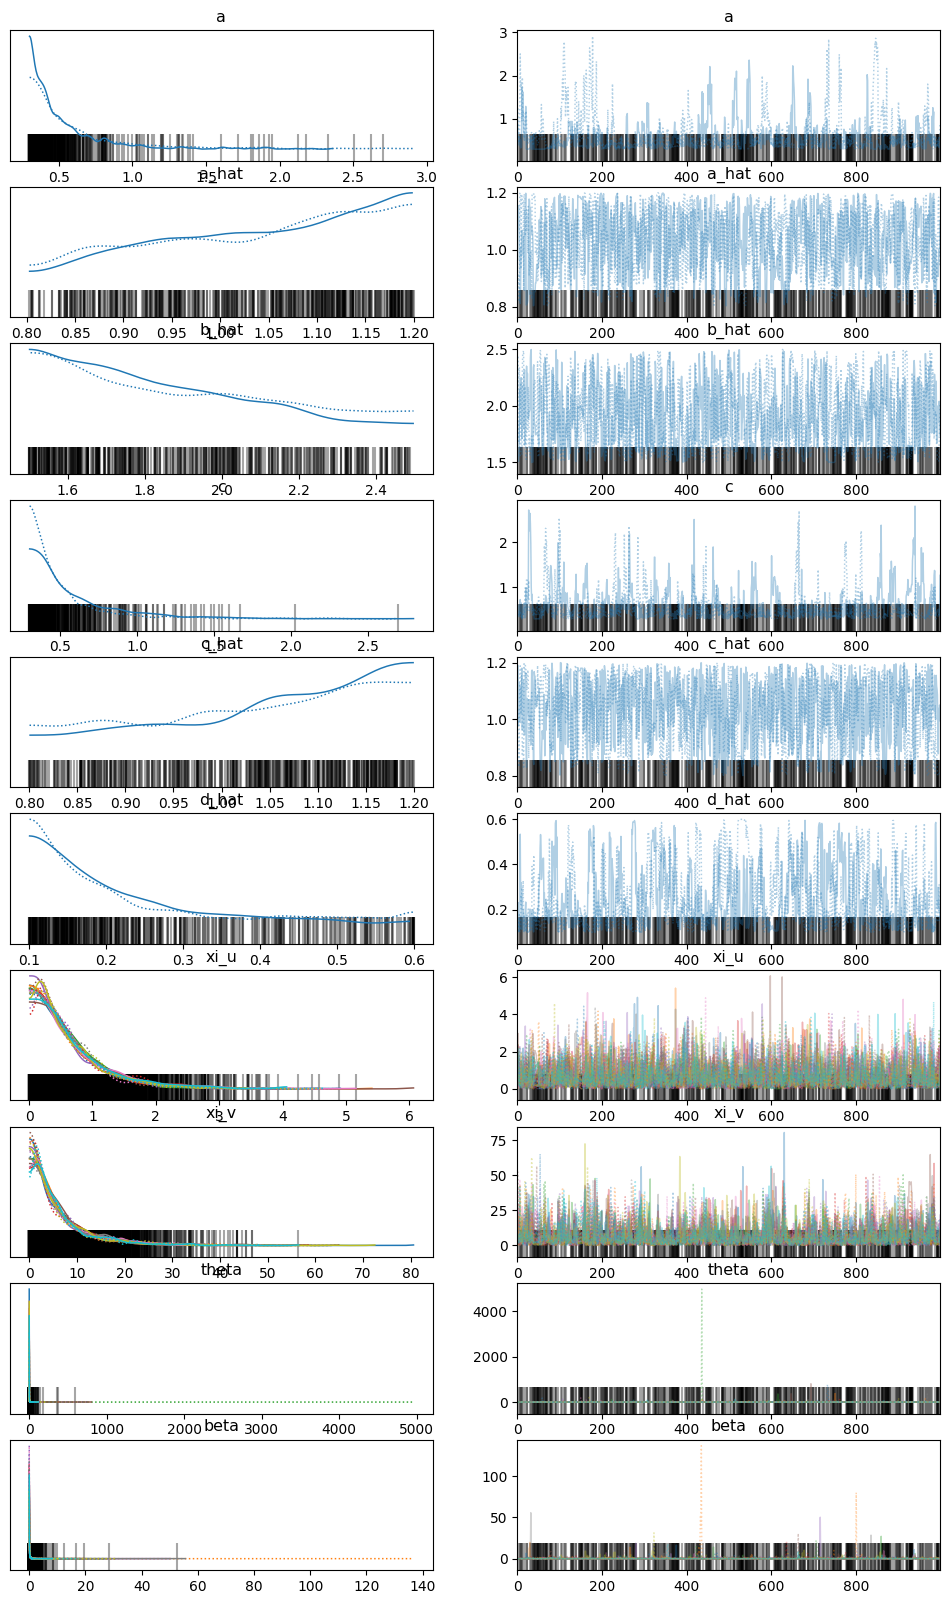

In [81]:
latent = len(all_categories)
# gamma_param = 1
with pm.Model() as model:
    y = pm.Data("y", interactions_sparse)

    a = pm.Uniform("a", lower=0.3, upper=3)
    a_hat = pm.Uniform("a_hat", lower=0.8, upper=1.2)
    b_hat = pm.Uniform("b_hat", lower=1.5, upper=2.5)
    c = pm.Uniform("c", lower=0.3, upper=3)
    c_hat = pm.Uniform("c_hat", lower=0.8, upper=1.2)
    d_hat = pm.Uniform("d_hat", lower=0.1, upper=0.6)

    xi_u = pm.Gamma('xi_u', alpha=a_hat, beta=b_hat, shape=n_users)
    xi_v = pm.Gamma('xi_v', alpha=c_hat, beta=d_hat, shape=n_items)

    # Define the latent factors for users and items
    theta = pm.Gamma('theta', alpha=a, beta=xi_u, shape=n_users)
    beta = pm.Gamma('beta', alpha=c, beta=xi_v, shape=n_items)

    # Define the likelihood
    likelihood = pm.Poisson('likelihood', mu=pm.math.matrix_dot(theta.T, beta), observed=y)

# Perform inference
with model:
    start = pm.find_MAP()
    trace = pm.sample(1_000, start=start, tune=5_000)
    az.plot_trace(trace)

While the paramaters from the uniform distribution aren't stable at all, xi_u and xi_v seam to loo like a cut gaussian. This may be a good sign for our covnergence, however, their variances are pretty big. We can see similar effect on theta and beta, this time with way lower variances.

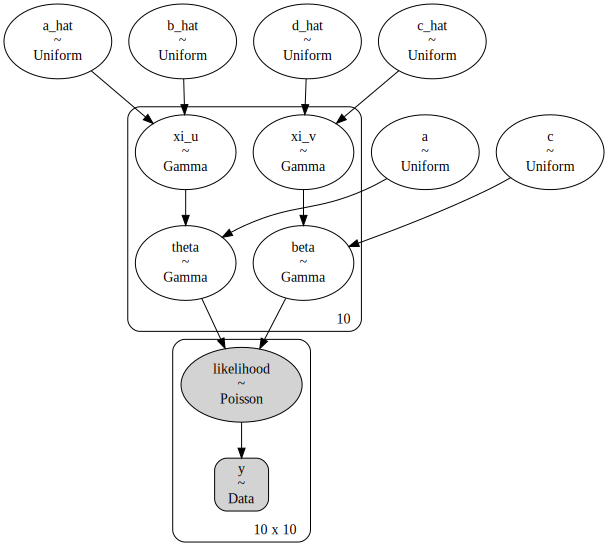

In [70]:
pm.model_to_graphviz(model)

(10, 10)
[[0.443 0.444 0.414 0.429 0.433 0.411 0.418 0.463 0.43  0.419]
 [0.415 0.439 0.435 0.415 0.418 0.449 0.408 0.415 0.404 0.437]
 [0.415 0.404 0.407 0.383 0.45  0.438 0.433 0.432 0.474 0.428]
 [0.412 0.406 0.407 0.407 0.433 0.456 0.408 0.37  0.438 0.466]
 [0.363 0.435 0.444 0.427 0.384 0.43  0.364 0.434 0.442 0.457]
 [0.436 0.438 0.42  0.405 0.416 0.427 0.442 0.419 0.405 0.444]
 [0.411 0.426 0.402 0.458 0.407 0.436 0.429 0.422 0.384 0.398]
 [0.426 0.436 0.437 0.425 0.416 0.406 0.399 0.452 0.45  0.45 ]
 [0.412 0.446 0.438 0.431 0.397 0.401 0.408 0.44  0.355 0.4  ]
 [0.429 0.434 0.434 0.428 0.414 0.404 0.417 0.434 0.434 0.41 ]]
The 'predictions' matrix has non-zero values.
The number of non-zero values in the predictions matrix is: 100
The number of non-zero values in the test matrix is: 10


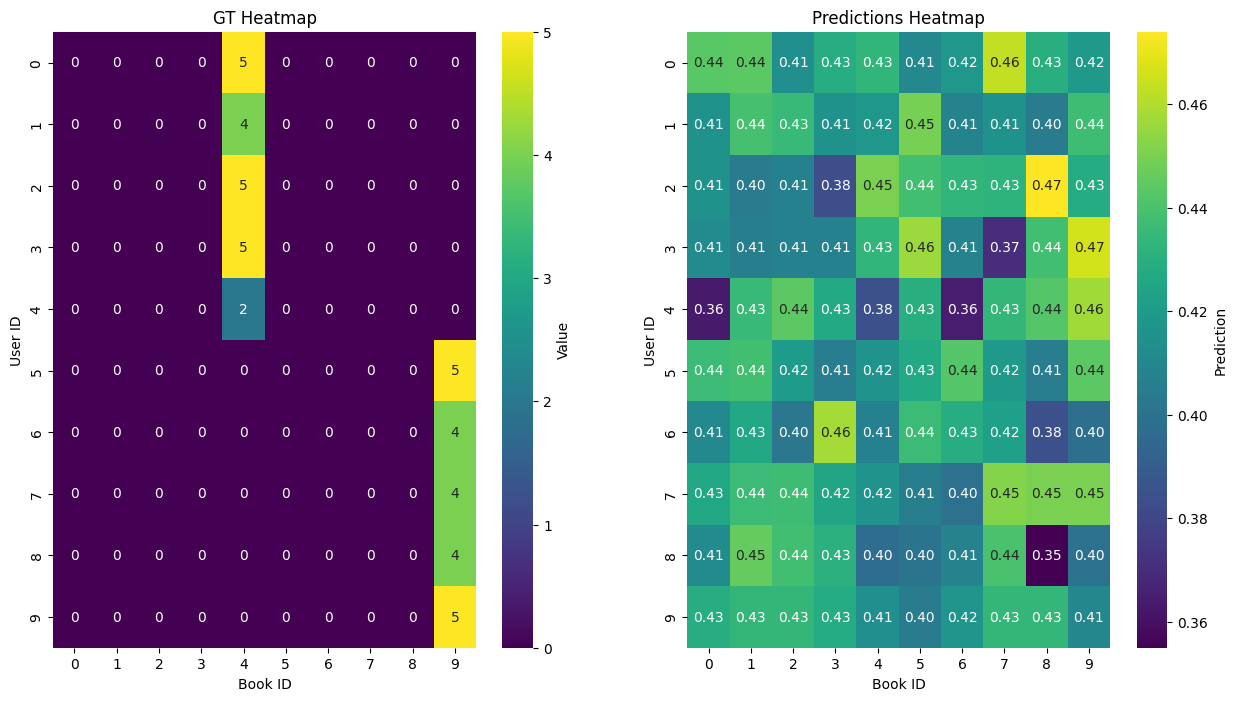

Top-1
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.11      0.20         9

    accuracy                           0.11         9
   macro avg       0.50      0.06      0.10         9
weighted avg       1.00      0.11      0.20         9



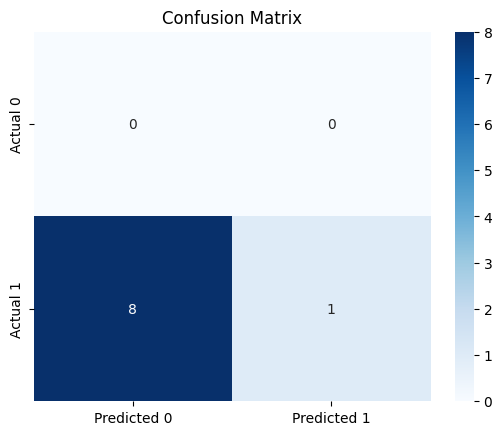

Top-2
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.22      0.36         9

    accuracy                           0.22         9
   macro avg       0.50      0.11      0.18         9
weighted avg       1.00      0.22      0.36         9



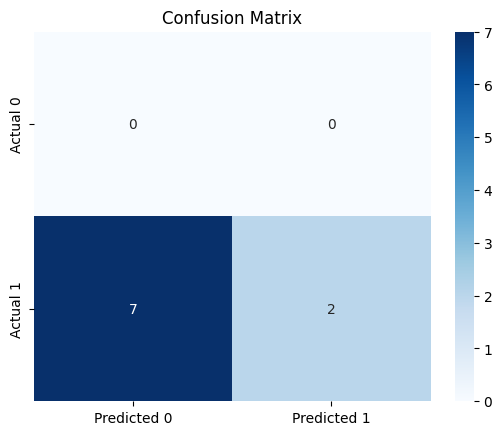

Top-3
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50         9

    accuracy                           0.33         9
   macro avg       0.50      0.17      0.25         9
weighted avg       1.00      0.33      0.50         9



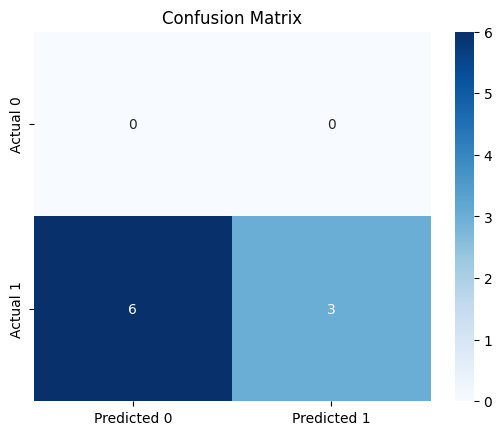

Top-4
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.56      0.71         9

    accuracy                           0.56         9
   macro avg       0.50      0.28      0.36         9
weighted avg       1.00      0.56      0.71         9



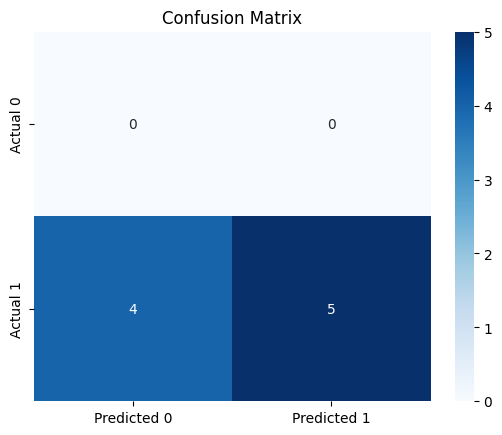

Top-5
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80         9

    accuracy                           0.67         9
   macro avg       0.50      0.33      0.40         9
weighted avg       1.00      0.67      0.80         9



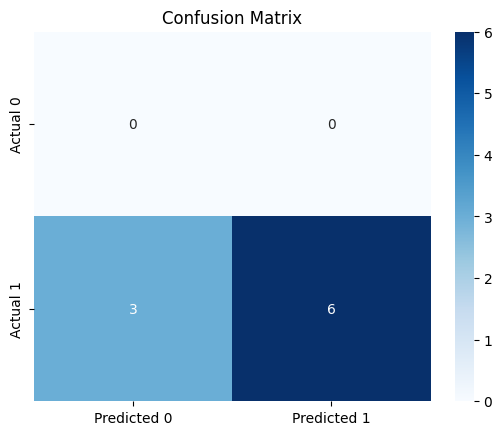

In [101]:
test_model(model, trace)

#### Blank model with two dimensions for theta & beta

Further more, I am gonna add a latent dimension to theta and beta, as proposed in the original HPF model.

Unfortunately I could not train this model due to memory issues.

In [ ]:
latent = len(all_categories)
# gamma_param = 1
with pm.Model() as model:
    y = pm.Data("y", interactions_sparse)
    a = pm.Uniform("a", lower=0.3, upper=3)
    a_hat = pm.Uniform("a_hat", lower=0.8, upper=1.2)
    b_hat = pm.Uniform("b_hat", lower=1.5, upper=2.5)
    c = pm.Uniform("c", lower=0.3, upper=3)
    c_hat = pm.Uniform("c_hat", lower=0.8, upper=1.2)
    d_hat = pm.Uniform("d_hat", lower=0.1, upper=0.6)

    xi_u = pm.Gamma('xi_u', alpha=a_hat, beta=b_hat, shape=(n_users,1))
    xi_v = pm.Gamma('xi_v', alpha=c_hat, beta=d_hat, shape=(n_items,1))

    # Define the latent factors for users and items
    theta = pm.Gamma('theta', alpha=a, beta=xi_u, shape=(n_users, latent))
    beta = pm.Gamma('beta', alpha=c, beta=xi_v, shape=(n_items, latent))

    # Define the likelihood
    likelihood = pm.Poisson('likelihood', mu=pm.math.matrix_dot(theta, beta.T), observed=y)

# Perform inference
with model:
    start = pm.find_MAP()
    trace = pm.sample(1_000, start=start, tune=5_000)
    az.plot_trace(trace)

In [ ]:
test_model(model, trace)

#### Model with observed frequencies and only one dimension for theta & beta

Now, I am also add the previous calculated frequencies as observed data.

/tmp/ipykernel_24984/4002124111.py:25: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1_000, start=start, tune=5_000)
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: divide by zero encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitt

Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 28 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


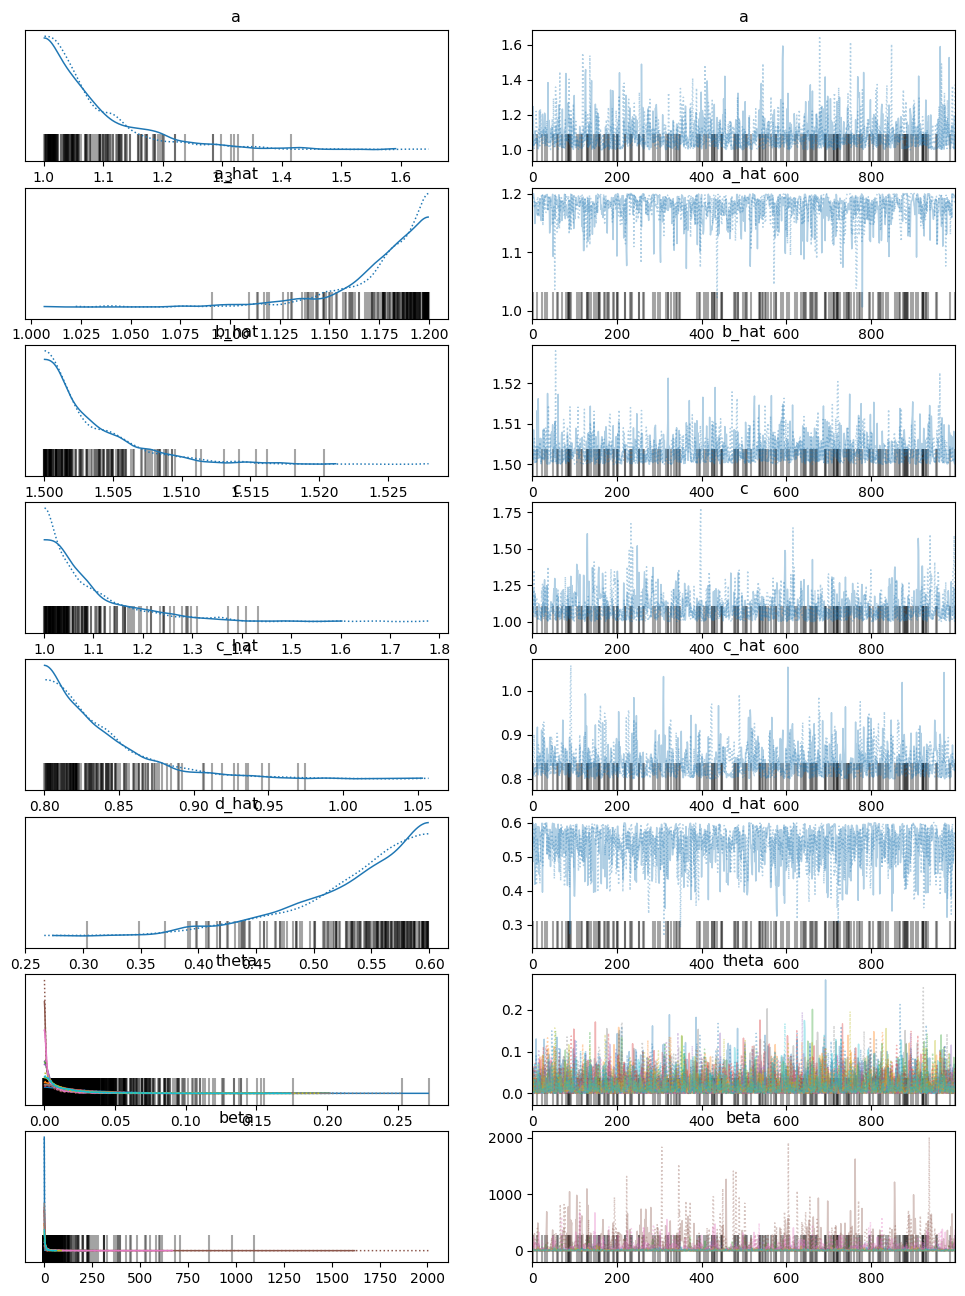

In [106]:
latent = len(all_categories)
# gamma_param = 1
with pm.Model() as model:
    y = pm.Data("y", interactions_sparse)
    a = pm.Uniform("a", lower=1, upper=3)
    a_hat = pm.Uniform("a_hat", lower=0.8, upper=1.2)
    b_hat = pm.Uniform("b_hat", lower=1.5, upper=2.5)
    c = pm.Uniform("c", lower=1, upper=3)
    c_hat = pm.Uniform("c_hat", lower=0.8, upper=1.2)
    d_hat = pm.Uniform("d_hat", lower=0.1, upper=0.6)

    xi_u = pm.Gamma('xi_u', alpha=a_hat, beta=b_hat, shape=n_users, observed=selected_users_freq)
    xi_v = pm.Gamma('xi_v', alpha=c_hat, beta=d_hat, shape=n_items, observed=selected_books_freq)

    # Define the latent factors for users and items
    theta = pm.Gamma('theta', alpha=a, beta=xi_u, shape=n_users)
    beta = pm.Gamma('beta', alpha=c, beta=xi_v, shape=n_items)

    # Define the likelihood
    likelihood = pm.Poisson('likelihood', mu=pm.math.matrix_dot(theta.T, beta), shape=[n_users, n_items], observed=y)

# Perform inference
with model:
    start = pm.find_MAP()
    trace = pm.sample(1_000, start=start, tune=5_000)
    az.plot_trace(trace)

This new observed data seam not to fit well with the priors, as so,the finale values are even worst. While I also tested out some other ranges for the uniforms, I did not gain better results.

(10, 10)
[[0.452 0.491 0.494 0.474 0.48  0.511 0.465 0.458 0.494 0.469]
 [0.468 0.485 0.441 0.469 0.466 0.449 0.463 0.461 0.446 0.49 ]
 [0.493 0.466 0.46  0.502 0.449 0.454 0.454 0.465 0.466 0.499]
 [0.501 0.441 0.476 0.511 0.442 0.501 0.452 0.492 0.464 0.46 ]
 [0.466 0.46  0.456 0.438 0.435 0.475 0.481 0.453 0.47  0.501]
 [0.458 0.476 0.469 0.431 0.477 0.483 0.481 0.459 0.464 0.481]
 [0.488 0.451 0.486 0.465 0.448 0.478 0.534 0.47  0.482 0.466]
 [0.475 0.481 0.502 0.489 0.498 0.473 0.449 0.5   0.487 0.477]
 [0.51  0.485 0.468 0.491 0.447 0.502 0.478 0.494 0.434 0.505]
 [0.488 0.466 0.487 0.437 0.495 0.499 0.486 0.421 0.438 0.485]]
The 'predictions' matrix has non-zero values.
The number of non-zero values in the predictions matrix is: 100
The number of non-zero values in the test matrix is: 10


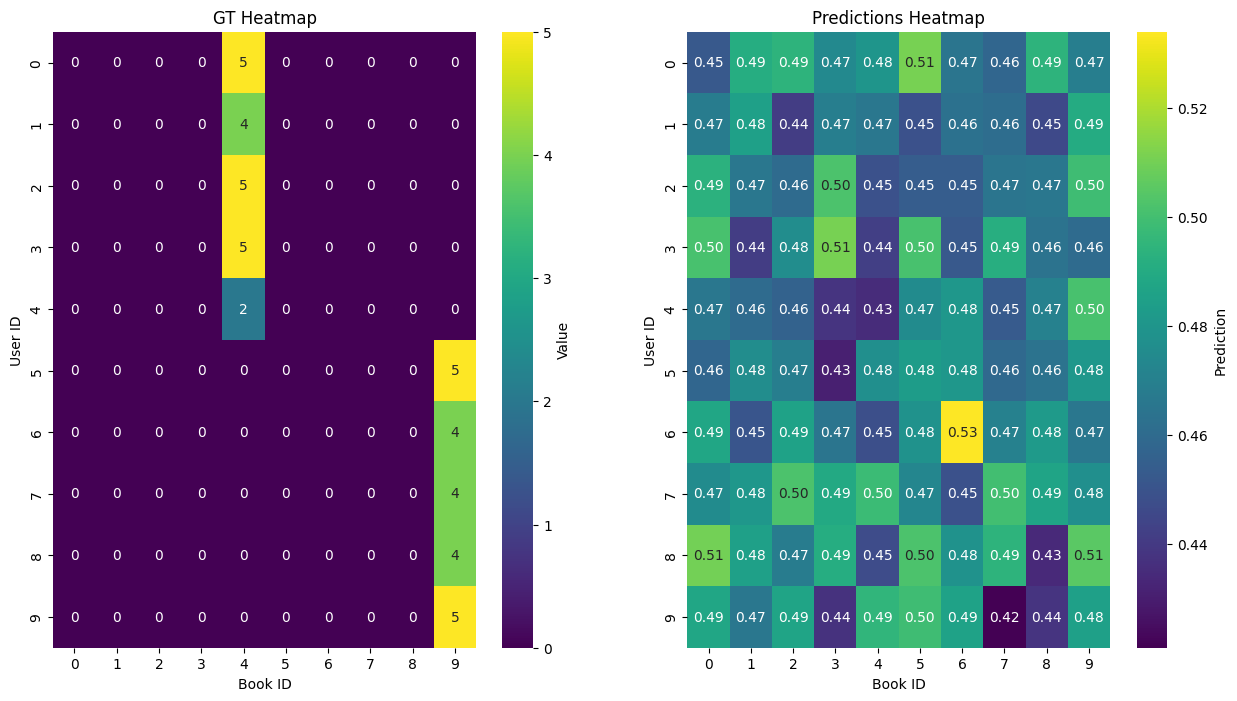

Top-1
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00       9.0

    accuracy                           0.00       9.0
   macro avg       0.00      0.00      0.00       9.0
weighted avg       0.00      0.00      0.00       9.0



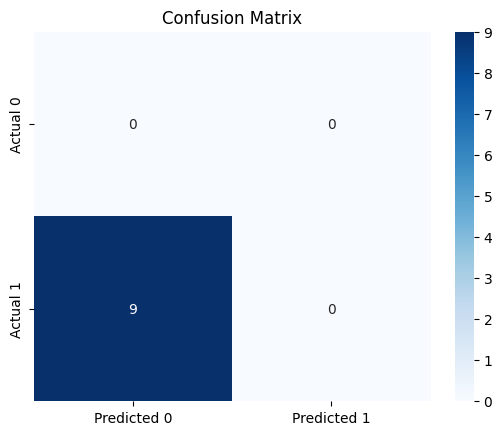

Top-2
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.11      0.20         9

    accuracy                           0.11         9
   macro avg       0.50      0.06      0.10         9
weighted avg       1.00      0.11      0.20         9



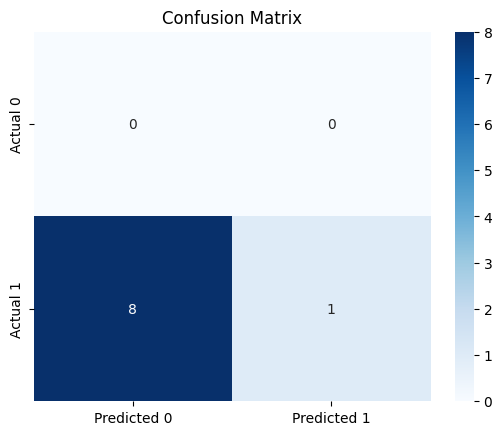

Top-3
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.22      0.36         9

    accuracy                           0.22         9
   macro avg       0.50      0.11      0.18         9
weighted avg       1.00      0.22      0.36         9



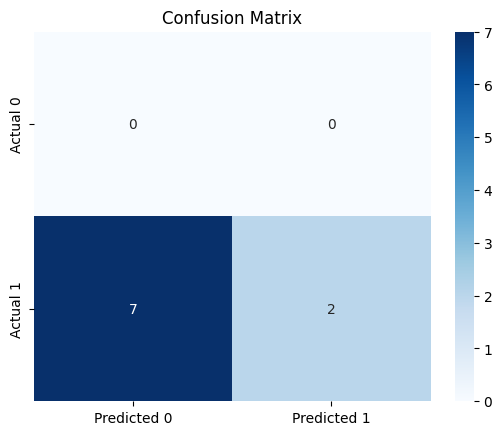

Top-4
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.22      0.36         9

    accuracy                           0.22         9
   macro avg       0.50      0.11      0.18         9
weighted avg       1.00      0.22      0.36         9



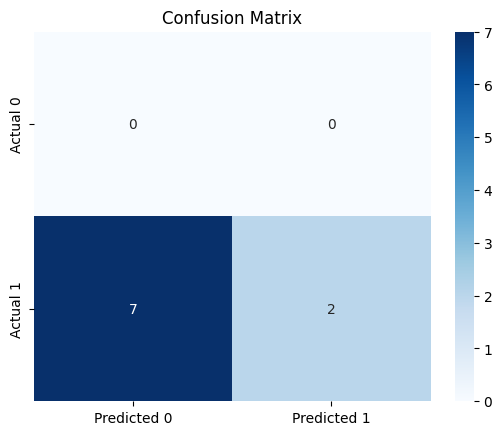

Top-5
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.44      0.62         9

    accuracy                           0.44         9
   macro avg       0.50      0.22      0.31         9
weighted avg       1.00      0.44      0.62         9



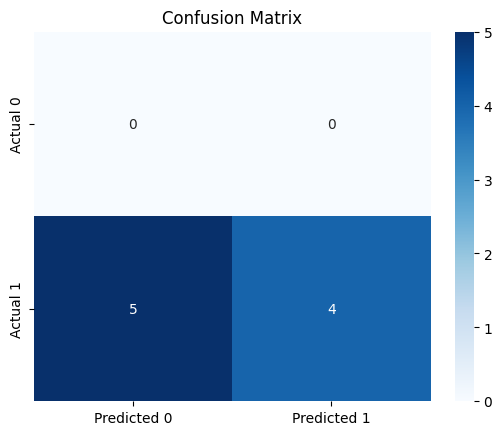

In [109]:
test_model(model, trace)

#### Model with observed frequencies and two dimensions for theta & beta

We also added again some latent dimensions, but this model crashed as well due to memory.

In [ ]:
latent = len(all_categories)

# gamma_param = 1
with pm.Model() as model:
    y = pm.Data("y", interactions_sparse)
    a = pm.Uniform("a", lower=1, upper=3)
    a_hat = pm.Uniform("a_hat", lower=0.8, upper=1.2)
    b_hat = pm.Uniform("b_hat", lower=1.5, upper=2.5)
    c = pm.Uniform("c", lower=1, upper=3)
    c_hat = pm.Uniform("c_hat", lower=0.8, upper=1.2)
    d_hat = pm.Uniform("d_hat", lower=0.1, upper=0.6)

    xi_u = pm.Gamma('xi_u', alpha=a_hat, beta=b_hat, shape=(n_users,1), observed=selected_users_freq)
    xi_v = pm.Gamma('xi_v', alpha=c_hat, beta=d_hat, shape=(n_items,1), observed=selected_books_freq)

    # Define the latent factors for users and items
    theta = pm.Gamma('theta', alpha=a, beta=xi_u, shape=(latent, n_users))
    beta = pm.Gamma('beta', alpha=c, beta=xi_v, shape=(latent, n_items))

    # Define the likelihood
    likelihood = pm.Poisson('likelihood', mu=pm.math.matrix_dot(theta.T, beta), shape=[n_users, n_items], observed=y)

# Perform inference
with model:
    start = pm.find_MAP()
    trace = pm.sample(1_000, start=start, tune=5_000, return_inferencedata=False)


In [ ]:
az.plot_trace(trace)

In [ ]:
test_model(model, trace)

#### Model with observed frequencies and atributes and only one dimension for theta & beta

Finally we used both frequencies and preferences as observed data.

In [111]:
latent = len(all_categories)
# gamma_param = 1

with pm.Model() as model:
    y = pm.Data("y", interactions_sparse)
    a = pm.Uniform("a", lower=1, upper=3)
    a_hat = pm.Uniform("a_hat", lower=0.8, upper=1.2)
    b_hat = pm.Uniform("b_hat", lower=1.5, upper=2.5)
    c = pm.Uniform("c", lower=1, upper=3)
    c_hat = pm.Uniform("c_hat", lower=0.8, upper=1.2)
    d_hat = pm.Uniform("d_hat", lower=0.1, upper=0.6)

    xi_u = pm.Gamma('xi_u', alpha=a_hat, beta=b_hat, shape=n_users, observed=selected_users_freq)
    xi_v = pm.Gamma('xi_v', alpha=c_hat, beta=d_hat, shape=n_items, observed=selected_books_freq)

    # Define the latent factors for users and items
    theta = pm.Gamma('theta', alpha=a, beta=xi_u, shape=n_users, observed=np.array(selected_users_preferences)/max(np.array(selected_users_preferences)))
    beta = pm.Gamma('beta', alpha=c, beta=xi_v, shape=n_items, observed=np.array(selected_books_atributes)/max(np.array(selected_books_atributes)))

    # Define the likelihood
    likelihood = pm.Poisson('likelihood', mu=pm.math.matrix_dot(theta.T, beta), shape=[n_users, n_items], observed=y)

# Perform inference
with model:
    start = pm.find_MAP()
    trace = pm.sample(1_000, start=start, tune=5_000)
    

/tmp/ipykernel_24984/1084111775.py:26: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1_000, start=start, tune=5_000)
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d_hat, c_hat, c, b_hat, a_hat, a]


Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 7 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'a_hat'}>,
        <Axes: title={'center': 'a_hat'}>],
       [<Axes: title={'center': 'b_hat'}>,
        <Axes: title={'center': 'b_hat'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'c_hat'}>,
        <Axes: title={'center': 'c_hat'}>],
       [<Axes: title={'center': 'd_hat'}>,
        <Axes: title={'center': 'd_hat'}>]], dtype=object)

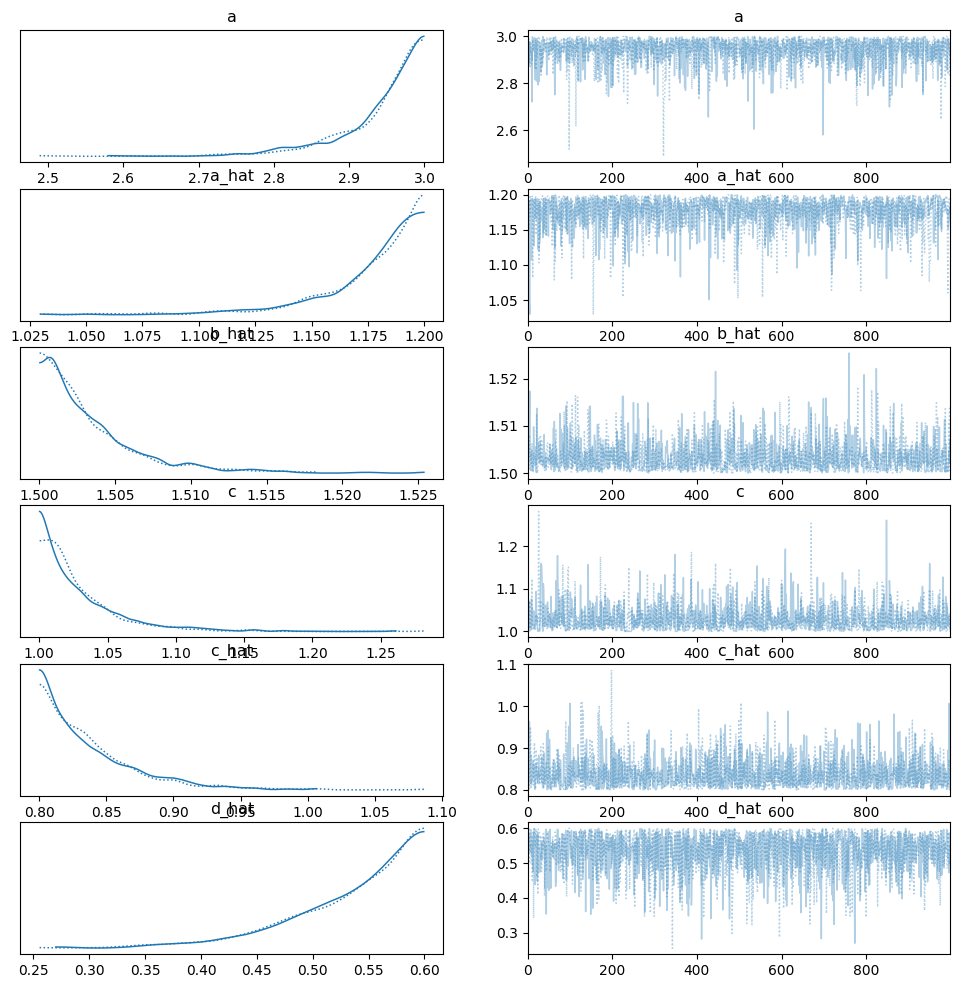

In [112]:
az.plot_trace(trace)

(10, 10)
[[2608.07  2603.297 2606.673 2601.739 2606.144 2605.404 2607.801 2604.65
  2604.034 2604.696]
 [2606.23  2604.603 2604.31  2605.47  2605.855 2604.409 2606.018 2604.369
  2604.384 2604.777]
 [2606.013 2603.805 2604.836 2602.519 2605.3   2605.598 2604.165 2607.804
  2604.687 2602.856]
 [2607.868 2604.631 2607.15  2605.43  2605.875 2602.8   2602.629 2603.584
  2604.85  2602.494]
 [2601.75  2607.603 2604.792 2602.913 2606.058 2604.898 2600.896 2603.381
  2605.956 2604.155]
 [2605.384 2606.109 2608.195 2605.39  2604.974 2606.062 2604.736 2604.813
  2603.179 2605.337]
 [2606.745 2605.148 2607.305 2606.826 2606.726 2604.581 2603.352 2605.2
  2602.852 2603.601]
 [2605.034 2606.322 2604.933 2606.756 2610.442 2604.986 2605.633 2602.426
  2604.855 2608.388]
 [2607.476 2602.682 2606.886 2603.65  2605.319 2604.923 2603.532 2604.201
  2603.179 2602.623]
 [2604.654 2604.52  2604.512 2606.166 2606.829 2604.294 2603.59  2603.864
  2605.691 2607.697]]
The 'predictions' matrix has non-zero value

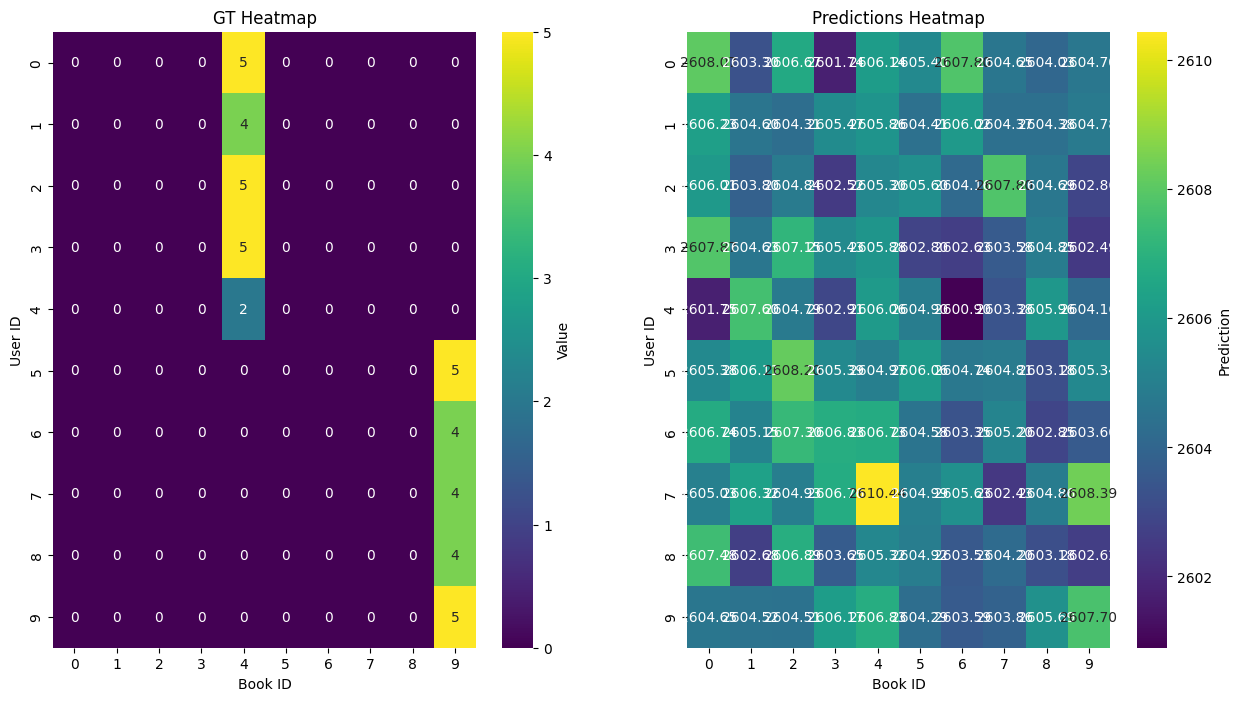

Top-1
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.11      0.20         9

    accuracy                           0.11         9
   macro avg       0.50      0.06      0.10         9
weighted avg       1.00      0.11      0.20         9



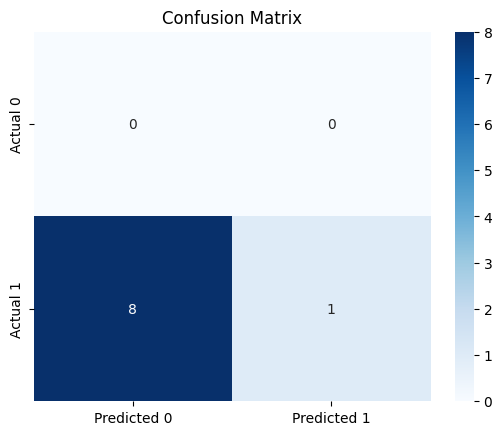

Top-2
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.22      0.36         9

    accuracy                           0.22         9
   macro avg       0.50      0.11      0.18         9
weighted avg       1.00      0.22      0.36         9



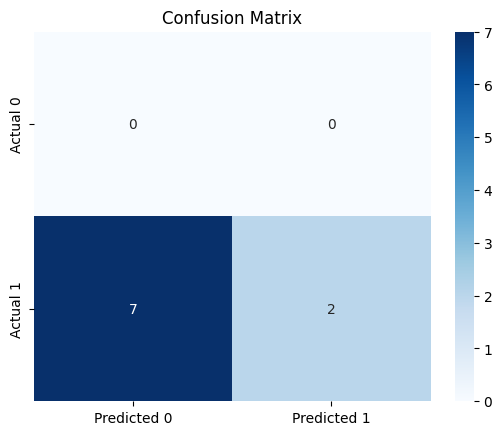

Top-3
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.44      0.62         9

    accuracy                           0.44         9
   macro avg       0.50      0.22      0.31         9
weighted avg       1.00      0.44      0.62         9



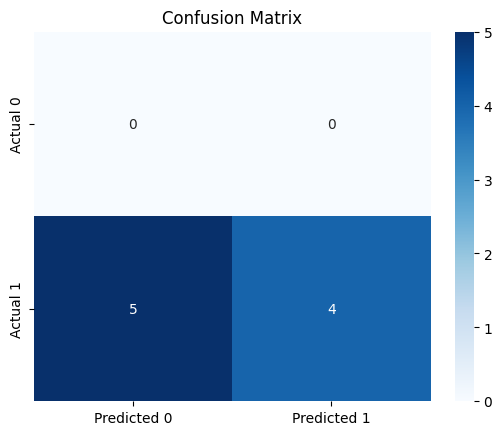

Top-4
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80         9

    accuracy                           0.67         9
   macro avg       0.50      0.33      0.40         9
weighted avg       1.00      0.67      0.80         9



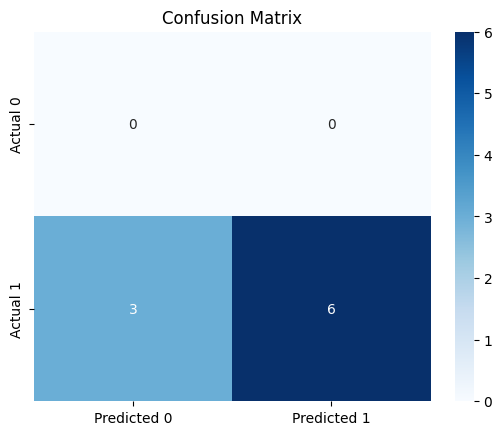

Top-5
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80         9

    accuracy                           0.67         9
   macro avg       0.50      0.33      0.40         9
weighted avg       1.00      0.67      0.80         9



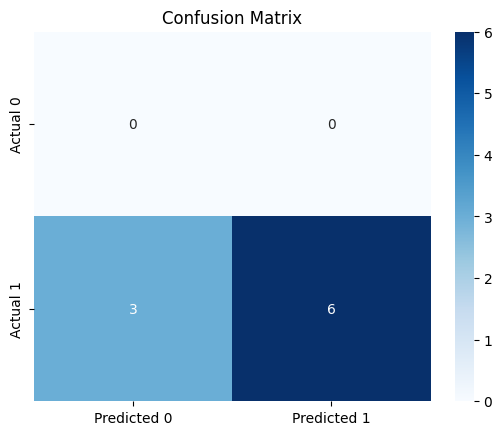

In [113]:
test_model(model, trace)

#### Model with observed frequencies and atributes and two dimensions for theta & beta

We also added the latent dimension here as well, but without being able to train it.

In [ ]:
latent = len(all_categories)
# gamma_param = 1
with pm.Model() as model:
    y = pm.Data("y", interactions_sparse)
    a = pm.Uniform("a", lower=0, upper=0.3)
    a_hat = pm.Uniform("a_hat", lower=0, upper=0.3)
    b_hat = pm.Uniform("b_hat", lower=0, upper=0.3)
    c = pm.Uniform("c", lower=0, upper=0.3)
    c_hat = pm.Uniform("c_hat", lower=0, upper=0.3)
    d_hat = pm.Uniform("d_hat", lower=0, upper=0.3)


    xi_u = pm.Gamma('xi_u', alpha=a_hat, beta=b_hat, shape=(n_users, 1), observed=selected_users_freq)
    xi_v = pm.Gamma('xi_v', alpha=c_hat, beta=d_hat, shape=(n_items, 1), observed=selected_books_freq)

    # Define the latent factors for users and items
    theta = pm.Gamma('theta', alpha=a, beta=xi_u, shape=(latent, n_users), observed=old_selected_users_preferences.T)
    beta = pm.Gamma('beta', alpha=c, beta=xi_v, shape=(latent, n_items), observed=old_selected_books_atributes.T)

    # Define the likelihood
    likelihood = pm.Poisson('likelihood', mu=pm.math.matrix_dot(theta.T, beta), shape=[n_users, n_items], observed=y)

# Perform inference
with model:
    start = pm.find_MAP()
    trace = pm.sample(1_000, start=start, tune=5_000)

In [ ]:
az.plot_trace(trace)

In [ ]:
test_model(model, trace)

### Best model train on 100 x 100 data

I am gonna use the same ideas and the first model from the sanity check, but for a matrix of 100 x 100 this time and with longer tuning.

### Train data


In [ ]:
n = 100
selected_user_freq = sorted(np.random.randint(low=1, high=50, size=n), reverse=True)
categorie_treshold = n // 3
selected_categories = []

selected_users = set()
selected_books = set()


for k, value in enumerate(selected_user_freq):
    for user_id in user_freq.keys():
        if user_freq[user_id] == value:
            book_id = ratings_df[ratings_df["user_id"] == user_id].iloc[0]["book_id"]
            categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
            included = False
            for c in categories:
                if c in selected_categories:
                    included = True
            if (k <= categorie_treshold and (len(selected_categories) == 0 or not included)) or (k > categorie_treshold and included):
                for c in categories:
                    selected_categories.append(c)

                if len(selected_users) < n:
                    selected_users.add(user_id)
                if len(selected_books) < n:
                    selected_books.add(book_id)
                if len(selected_books) == n or k <= categorie_treshold:
                    break

print(len(selected_users), len(selected_books))

100 100


In [ ]:
print(len(selected_users), len(selected_books))

100 100


In [ ]:
selected_users_freq = [user_freq[id] for id in selected_users if id in user_freq.keys()]
selected_books_freq = [book_freq[id] for id in selected_books if id in book_freq.keys()]
print(len(selected_users_freq), len(selected_books_freq))

100 100


In [ ]:
old_selected_users_preferences = np.zeros((len(selected_users),len(all_categories)))

for k, user_id in enumerate(selected_users):
    relevant_book_ids = ratings_df[ratings_df['user_id'] == user_id]['book_id'].unique()
    filtered_books_df = books_df[books_df['book_id'].isin(relevant_book_ids)]['book_id'].values

    for book_id in filtered_books_df:
        categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
        for c in categories:
            index = list(all_categories).index(c)
            old_selected_users_preferences[k][index] += 1

    old_selected_users_preferences[k] = old_selected_users_preferences[k] / np.sum(old_selected_users_preferences[k])

selected_users_preferences = np.zeros(len(selected_users))
for k in range(len(selected_users_preferences)):
    selected_users_preferences[k] = np.argmax(old_selected_users_preferences[k])

In [ ]:
old_selected_books_atributes = np.zeros((len(selected_books), len(all_categories)))

for k, book_id in enumerate(selected_books):
    categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
    for c in categories:
        index = list(all_categories).index(c)
        old_selected_books_atributes[k][index] += 1

    old_selected_books_atributes[k] = old_selected_books_atributes[k] / np.sum(old_selected_books_atributes[k])

selected_books_atributes = np.zeros(len(selected_books))
for k in range(len(selected_books_atributes)):
    selected_books_atributes[k] = np.argmax(old_selected_books_atributes[k])

In [ ]:
ratings_df['user_id'] = ratings_df['user_id'].astype(int)
ratings_df['book_id'] = ratings_df['book_id'].astype(int)
print(len(selected_users), len(selected_books))

# Filter the DataFrame based on selected users and books
interactions_sparse = np.zeros((len(selected_users), len(selected_books)), dtype=int)

selected_rows = ratings_df[(ratings_df['user_id'].isin(selected_users)) & (ratings_df['book_id'].isin(selected_books))]
user_mapping = {user_id: u for u, user_id in enumerate(selected_users)}
book_mapping = {book_id: b for b, book_id in enumerate(selected_books)}

interactions_sparse[selected_rows['user_id'].map(user_mapping), selected_rows['book_id'].map(book_mapping)] = selected_rows['review/score'].values

# Display the resulting matrix
print("Matrix:")
print(interactions_sparse.shape)

n_users, n_items = interactions_sparse.shape

100 100
Matrix:
(100, 100)


In [ ]:
selected_users_preferences = np.array(selected_users_preferences)
selected_users_preferences = selected_users_preferences / max(selected_users_preferences)
selected_books_freq = np.array(selected_books_freq)
selected_books_freq = selected_books_freq / max(selected_books_freq)

### Test Data

In [ ]:
n = 100

test_selected_users = ratings_df['user_id'].tail(n)
test_selected_books = ratings_df['book_id'].tail(n)

In [ ]:
print(len(test_selected_users), len(test_selected_books))

100 100


In [ ]:
test_selected_users_freq = [user_freq[id] for id in test_selected_users if id in user_freq.keys()]
test_selected_books_freq = [book_freq[id] for id in test_selected_books if id in book_freq.keys()]
print(len(test_selected_users_freq), len(test_selected_books_freq))

100 100


In [ ]:
test_old_selected_users_preferences = np.zeros((len(test_selected_users),len(all_categories)))

for k, user_id in enumerate(test_selected_users):
    relevant_book_ids = ratings_df[ratings_df['user_id'] == user_id]['book_id'].unique()
    filtered_books_df = books_df[books_df['book_id'].isin(relevant_book_ids)]['book_id'].values

    for book_id in filtered_books_df:
        categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
        for c in categories:
            index = list(all_categories).index(c)
            test_old_selected_users_preferences[k][index] += 1

    test_old_selected_users_preferences[k] = test_old_selected_users_preferences[k] / np.sum(test_old_selected_users_preferences[k])

test_selected_users_preferences = np.zeros(len(test_selected_users))
for k in range(len(selected_users_preferences)):
    test_selected_users_preferences[k] = np.argmax(test_old_selected_users_preferences[k])

In [ ]:
test_old_selected_books_atributes = np.zeros((len(test_selected_books), len(all_categories)))

for k, book_id in enumerate(test_selected_books):
    categories = books_df[books_df["book_id"] == book_id].iloc[0]["categories"]
    for c in categories:
        index = list(all_categories).index(c)
        test_old_selected_books_atributes[k][index] += 1

    test_old_selected_books_atributes[k] = test_old_selected_books_atributes[k] / np.sum(test_old_selected_books_atributes[k])

test_selected_books_atributes = np.zeros(len(test_selected_books))
for k in range(len(test_selected_books_atributes)):
    test_selected_books_atributes[k] = np.argmax(test_old_selected_books_atributes[k])

In [ ]:
ratings_df['user_id'] = ratings_df['user_id'].astype(int)
ratings_df['book_id'] = ratings_df['book_id'].astype(int)
print(len(test_selected_users), len(test_selected_books))

# Filter the DataFrame based on selected users and books
test_interactions_sparse = np.zeros((len(test_selected_users), len(test_selected_books)), dtype=int)

test_selected_rows = ratings_df[(ratings_df['user_id'].isin(test_selected_users)) & (ratings_df['book_id'].isin(test_selected_books))]
user_mapping = {user_id: u for u, user_id in enumerate(test_selected_users)}
book_mapping = {book_id: b for b, book_id in enumerate(test_selected_books)}

test_interactions_sparse[test_selected_rows['user_id'].map(user_mapping), test_selected_rows['book_id'].map(book_mapping)] = test_selected_rows['review/score'].values

# Display the resulting matrix
print("Matrix:")
print(test_interactions_sparse.shape)

test_n_users, test_n_items = test_interactions_sparse.shape

100 100
Matrix:
(100, 100)


In [ ]:
test_selected_users_preferences = np.array(test_selected_users_preferences)
test_selected_users_preferences = test_selected_users_preferences / max(test_selected_users_preferences)
test_selected_books_freq = np.array(test_selected_books_freq)
test_selected_books_freq = test_selected_books_freq / max(test_selected_books_freq)

### Save

In [ ]:
np.save("data_100.npy", [
    selected_users,
    selected_books,
    selected_users_freq,
    selected_books_freq,
    selected_users_preferences,
    old_selected_users_preferences,
    selected_books_atributes,
    old_selected_books_atributes,
    interactions_sparse,
    all_categories,
    n_users,
    n_items,
    test_selected_users,
    test_selected_books,
    test_selected_users_freq,
    test_selected_books_freq,
    test_selected_users_preferences,
    test_old_selected_users_preferences,
    test_selected_books_atributes,
    test_old_selected_books_atributes,
    test_interactions_sparse,
    test_n_users,
    test_n_items
])

/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### Models

In [ ]:
selected_users, selected_books, selected_users_freq, selected_books_freq, selected_users_preferences, old_selected_users_preferences, selected_books_atributes, old_selected_books_atributes, interactions_sparse, all_categories, n_users, n_items, test_selected_users, test_selected_books, test_selected_users_freq, test_selected_books_freq, test_selected_users_preferences, test_old_selected_users_preferences, test_selected_books_atributes, test_old_selected_books_atributes, test_interactions_sparse, test_n_users, test_n_items = np.load("data_100.npy", allow_pickle=True)

#### Blank model with only one dimension for theta & beta

/tmp/ipykernel_34038/2352693866.py:26: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(10_000, start=start, tune=50_000)
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: divide by zero encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
/home/mihail/anaconda3/envs/del_later/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, xi_v, xi_u, d_hat, c_hat, c, b_hat, a_hat, a]
/home/mihail/anaconda3/envs/del_later/lib/pyth

Sampling 2 chains for 50_000 tune and 10_000 draw iterations (100_000 + 20_000 draws total) took 1610 seconds.
There were 6240 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5040 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


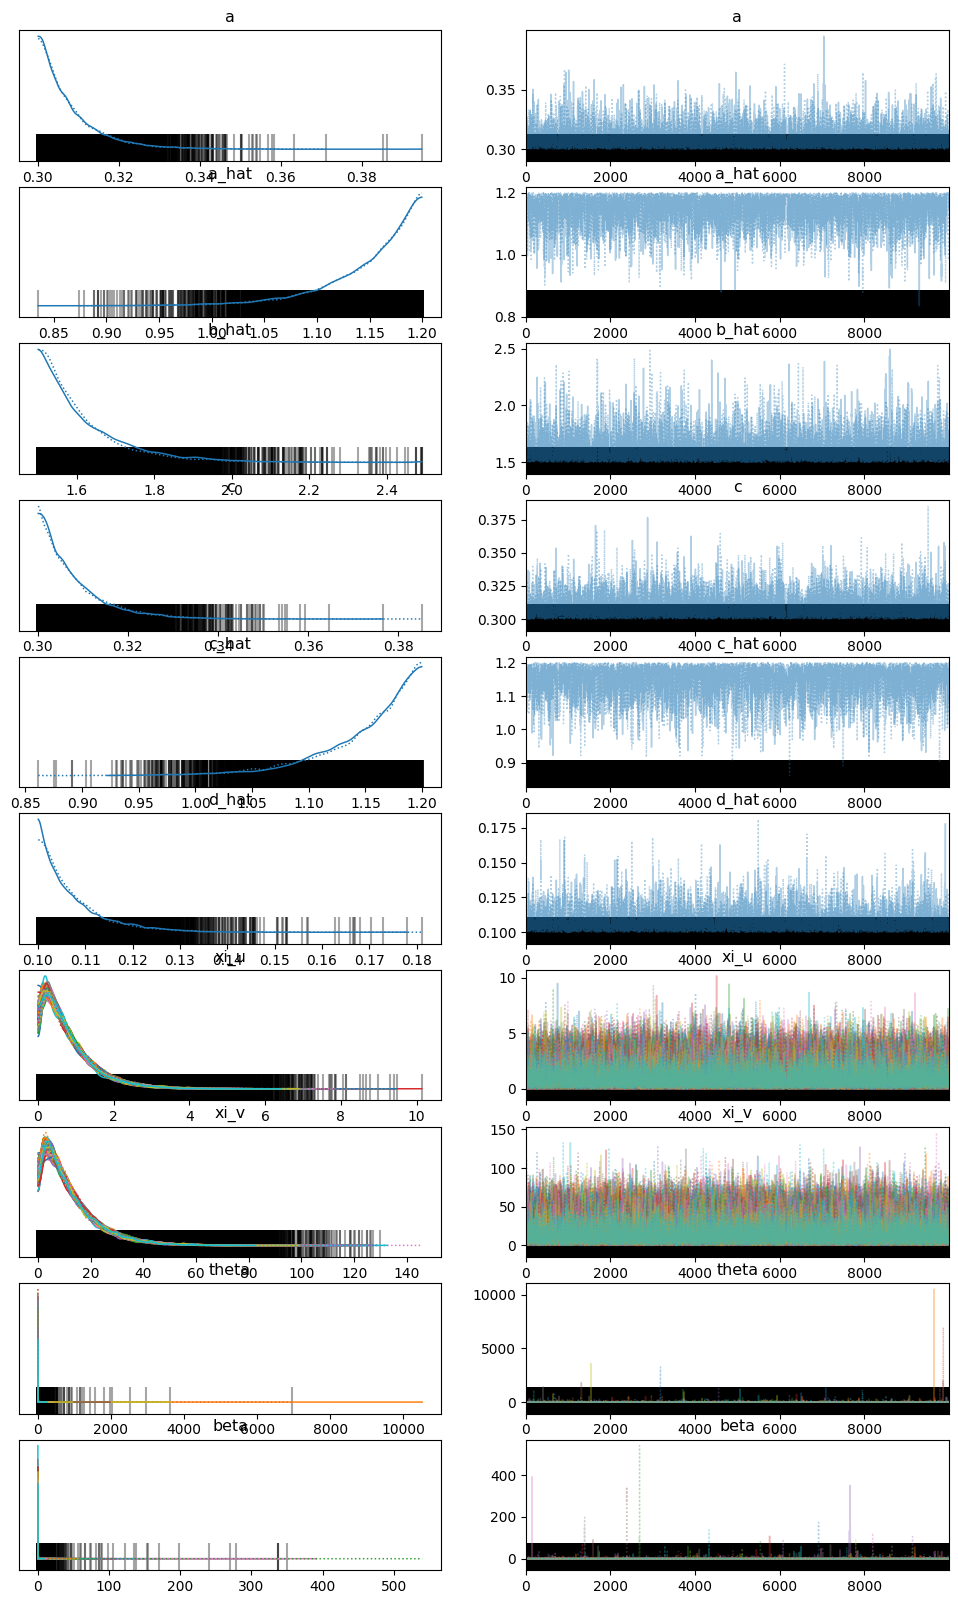

In [ ]:
latent = len(all_categories)
# gamma_param = 1
with pm.Model() as model:
    y = pm.Data("y", interactions_sparse)

    a = pm.Uniform("a", lower=0.3, upper=3)
    a_hat = pm.Uniform("a_hat", lower=0.8, upper=1.2)
    b_hat = pm.Uniform("b_hat", lower=1.5, upper=2.5)
    c = pm.Uniform("c", lower=0.3, upper=3)
    c_hat = pm.Uniform("c_hat", lower=0.8, upper=1.2)
    d_hat = pm.Uniform("d_hat", lower=0.1, upper=0.6)

    xi_u = pm.Gamma('xi_u', alpha=a_hat, beta=b_hat, shape=n_users)
    xi_v = pm.Gamma('xi_v', alpha=c_hat, beta=d_hat, shape=n_items)

    # Define the latent factors for users and items
    theta = pm.Gamma('theta', alpha=a, beta=xi_u, shape=n_users)
    beta = pm.Gamma('beta', alpha=c, beta=xi_v, shape=n_items)

    # Define the likelihood
    likelihood = pm.Poisson('likelihood', mu=pm.math.matrix_dot(theta.T, beta), observed=y)

# Perform inference
with model:
    start = pm.find_MAP()
    trace = pm.sample(10_000, start=start, tune=50_000)
    az.plot_trace(trace)

(100, 100)
[[0.041 0.063 0.058 ... 0.055 0.078 0.058]
 [0.048 0.056 0.052 ... 0.055 0.057 0.049]
 [0.049 0.064 0.073 ... 0.061 0.062 0.047]
 ...
 [0.065 0.059 0.053 ... 0.067 0.051 0.063]
 [0.063 0.061 0.056 ... 0.054 0.068 0.061]
 [0.061 0.047 0.07  ... 0.059 0.059 0.067]]
The 'predictions' matrix has non-zero values.
The number of non-zero values in the predictions matrix is: 10000
The number of non-zero values in the test matrix is: 99


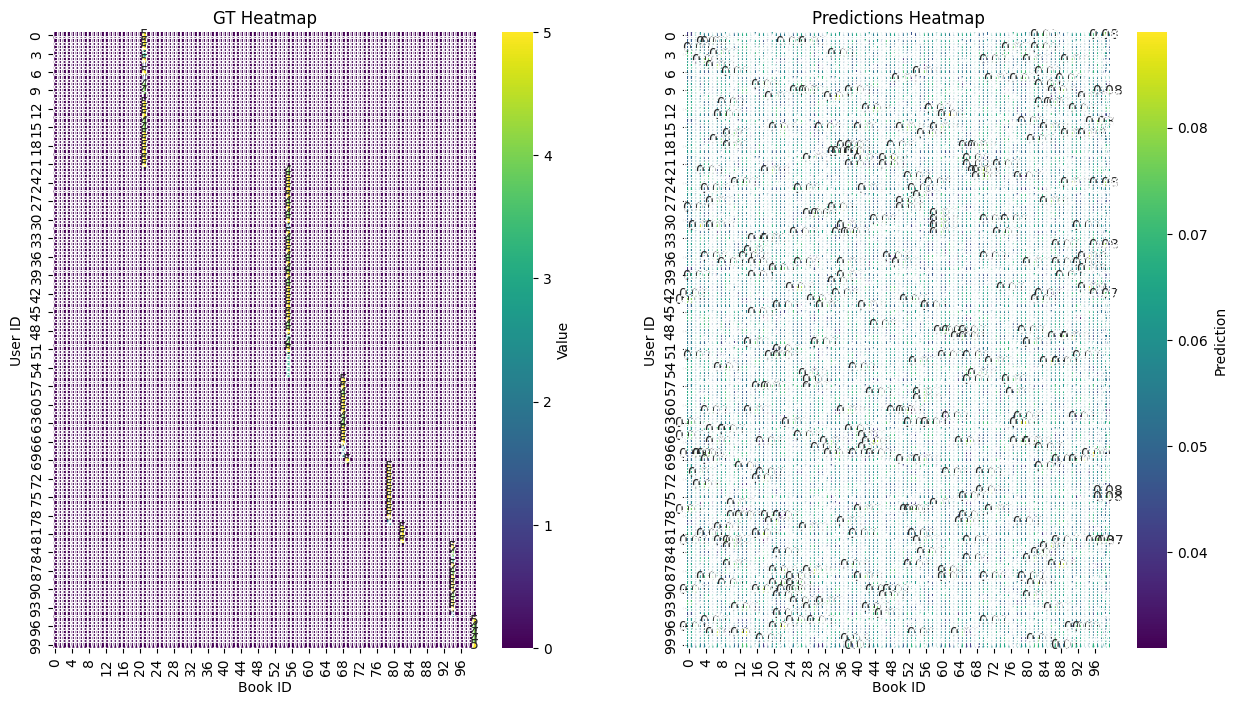

Top-1
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.02      0.05        85

    accuracy                           0.02        85
   macro avg       0.50      0.01      0.02        85
weighted avg       1.00      0.02      0.05        85



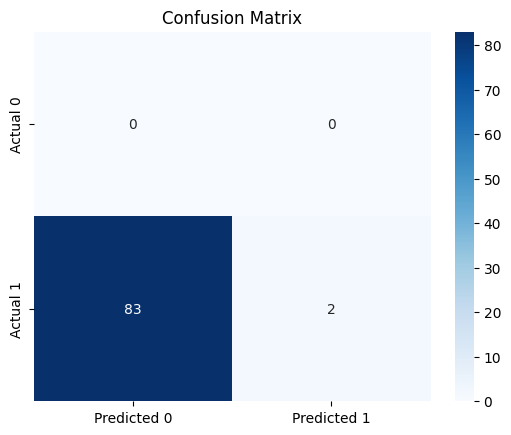

Top-2
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.02      0.05        85

    accuracy                           0.02        85
   macro avg       0.50      0.01      0.02        85
weighted avg       1.00      0.02      0.05        85



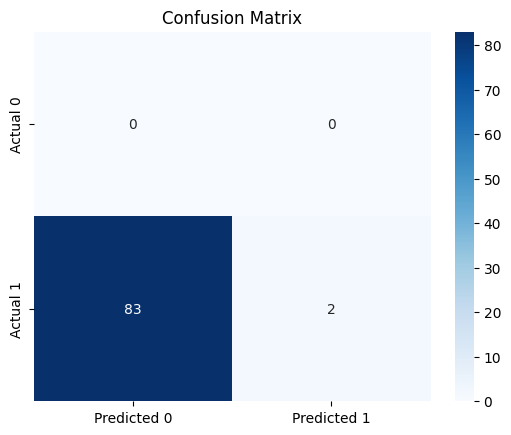

Top-3
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.02      0.05        85

    accuracy                           0.02        85
   macro avg       0.50      0.01      0.02        85
weighted avg       1.00      0.02      0.05        85



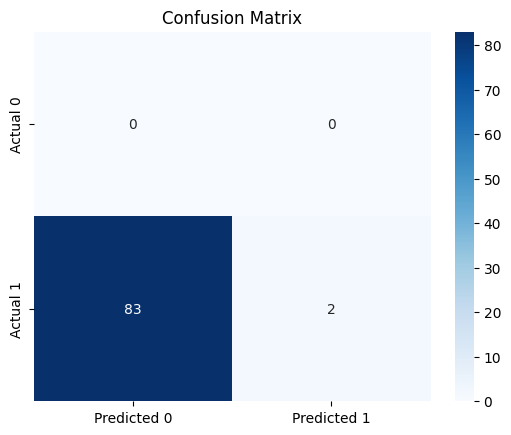

Top-4
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.05      0.09        85

    accuracy                           0.05        85
   macro avg       0.50      0.02      0.04        85
weighted avg       1.00      0.05      0.09        85



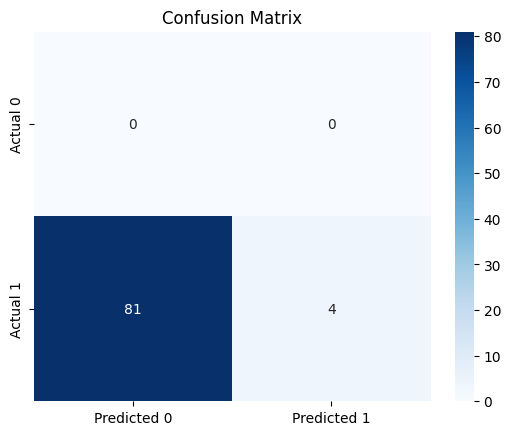

Top-5
Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.05      0.09        85

    accuracy                           0.05        85
   macro avg       0.50      0.02      0.04        85
weighted avg       1.00      0.05      0.09        85



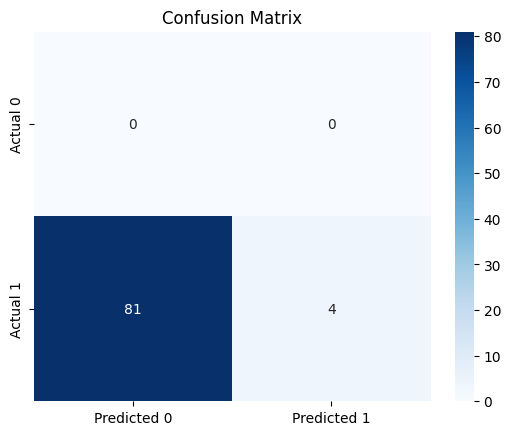

In [ ]:
test_model(model, trace)

The best performance I got is using a top-4 accuracy, where the model performed with 5%.